In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.basemap import Basemap
import geopandas as gpd
import numpy as np
import warnings

## Obtener los datos


In [2]:
tipos_de_gastos_files_xls = [
    "data/input/gastos/alcaldia-tipos_de_gastos__alcaldia___2024-03-09T02_06_53.838153Z.xlsx",
    "data/input/gastos/gobernacion-tipos_de_gastos__2024-03-09T02_00_59.376388Z.xlsx",
]


gastos_df = pd.DataFrame()

for f in tipos_de_gastos_files_xls:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        df_temp = pd.read_excel(f, engine="openpyxl")

    gastos_df = pd.concat([gastos_df, df_temp], ignore_index=True)

## Renombrar las columnas
gastos_df = gastos_df.rename(
    columns={
        "Corporaciones - ID Corporacion → Nombre": "Cargo",
        "Formato Ingresos Gastos - ID Formato Ingresos Gasto → Codigo": "Gasto Id",
        "Candidatos → Sexo": "Sexo",
        "Candidatos → Etnia": "Etnia",
        "Departamentos - ID Departamento → Nombre": "Departamento",
        "Ciudades → Nombre": "Ciudades",
        "Agrupaciones Politicas → Nombre": "Agrupacion Politica",
        "Coalicion Politica → Nombre": "Coalicion Politica",
        "Grupos Significativos → Nombre": "Grupo Politico",
        "Suma de Gastos → Total": "Total",
    }
)


gastos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24308 entries, 0 to 24307
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Nombre               24308 non-null  object 
 1   Apellido             24308 non-null  object 
 2   Cargo                24308 non-null  object 
 3   Gasto Id             24308 non-null  int64  
 4   Sexo                 24306 non-null  object 
 5   Etnia                12321 non-null  float64
 6   Departamento         24308 non-null  object 
 7   Ciudades             23005 non-null  object 
 8   Agrupacion Politica  14245 non-null  object 
 9   Coalicion Politica   9057 non-null   object 
 10  Grupo Politico       827 non-null    object 
 11  Total                24308 non-null  float64
 12  Contar               24308 non-null  int64  
 13  Etnias               12321 non-null  object 
 14  Género               24306 non-null  object 
 15  Codigo Pro           24308 non-null 

### Convertir tres columnas con valores únicos a dos columnas con tipo y valor


In [3]:
columnas_originales = [
    "Agrupacion Politica",
    "Coalicion Politica",
    "Grupo Politico",
]


def categorizar(fila):
    aggPolitica = fila["Agrupacion Politica"]
    coalicionPolitica = fila["Coalicion Politica"]
    grupoPolitico = fila["Grupo Politico"]
    if isinstance(aggPolitica, str):
        return "Agrupacion Politica"
    if isinstance(coalicionPolitica, str):
        return "Coalicion Politica"
    if isinstance(grupoPolitico, str):
        return "Grupo Politico"


def categorizarConNombre(fila):
    aggPolitica = fila["Agrupacion Politica"]
    coalicionPolitica = fila["Coalicion Politica"]
    grupoPolitico = fila["Grupo Politico"]

    if isinstance(aggPolitica, str):
        return aggPolitica
    if isinstance(coalicionPolitica, str):
        return coalicionPolitica
    if isinstance(grupoPolitico, str):
        return grupoPolitico


gastos_df["Tipo de Agrupación"] = gastos_df.apply(categorizar, axis=1)
gastos_df["Nombre de Agrupación"] = gastos_df.apply(categorizarConNombre, axis=1)

gastos_df = gastos_df.drop(columns=columnas_originales)


def millions_billions_formatter(x, pos):
    if x >= 1e9:
        return f"{x / 1e9:.0f}B"
    elif x >= 1e6:
        return f"{x / 1e6:.0f}M"
    else:
        return f"{x:.0f}"


func_form_millon_billon = FuncFormatter(millions_billions_formatter)



def autoLabel():
    for bar in plt.gca().patches:
        height = bar.get_height()

        formatted_height = millions_billions_formatter(height, None)
        plt.gca().annotate(
            formatted_height,
            xy=(bar.get_x() + bar.get_width() / 2, height),
            xytext=(0, 3),  # Desplazamiento vertical del texto
            textcoords="offset points",
            ha="center",
            va="bottom",
        )


gastos_df.head()  ##Mostrar las primeras filas

Nombre       Apellido         Cargo  Gasto Id Sexo  Etnia  \
0  ABAD DE JESUS   MARIN ARCILA  Alcaldia_fun       205    M    NaN   
1  ABAD DE JESUS   MARIN ARCILA  Alcaldia_fun       207    M    NaN   
2  ABAD DE JESUS   MARIN ARCILA  Alcaldia_fun       208    M    NaN   
3  ABAD DE JESUS   MARIN ARCILA  Alcaldia_fun       211    M    NaN   
4   ABEL ALBERTO  POLANCO LEMOS  Alcaldia_fun       203    M    NaN   

  Departamento    Ciudades       Total  Contar Etnias     Género  \
0    Antioquia  San Rafael  10400000.0       3    NaN  Masculino   
1    Antioquia  San Rafael    200000.0       1    NaN  Masculino   
2    Antioquia  San Rafael   6030000.0       1    NaN  Masculino   
3    Antioquia  San Rafael   1570000.0       1    NaN  Masculino   
4      Bolívar    Tiquisio   3000000.0       1    NaN  Masculino   

                                          Codigo Pro   Tipo de Agrupación  \
0              205 - Servicio de transporte y correo  Agrupacion Politica   
1  207 - Gastos judiciales y de rendición de cuentas  Agrupacion Politica   
2               208 - Gastos de propaganda electoral  Agrupacion Politica   
3                                 211 - Otros gastos  Agrupacion Politica   
4      203 - Inversión en materiales y publicaciones  Agrupacion Politica   

          Nombre de Agrupación  
0  PARTIDO COLOMBIA RENACIENTE  
1  PARTIDO COLOMBIA RENACIENTE  
2  PARTIDO COLOMBIA RENACIENTE  
3  PARTIDO COLOMBIA RENACIENTE  
4    PARTIDO NUEVO LIBERALISMO

### Concatenar nombre y apellidos

In [4]:
# gastos_df['Nombre'] = gastos_df['Nombre'].str.strip().str.lower().str.replace(' ', '_')

# Concatenar 'Nombre' y 'Apellido' en una nueva columna 'Nombre Completo'
gastos_df['Nombre'] = gastos_df['Nombre'].str.strip().str.lower().str.replace(' ', '_') + '_' + gastos_df['Apellido'].str.strip().str.lower().str.replace(' ', '_')

In [5]:

gastos_df.drop(columns=["Apellido","Género","Etnia","Etnias"], axis=2,inplace=True)
gastos_df.shape


(24308, 11)

In [6]:
gastos_df

Nombre         Cargo  Gasto Id Sexo  \
0           abad_de_jesus_marin_arcila  Alcaldia_fun       205    M   
1           abad_de_jesus_marin_arcila  Alcaldia_fun       207    M   
2           abad_de_jesus_marin_arcila  Alcaldia_fun       208    M   
3           abad_de_jesus_marin_arcila  Alcaldia_fun       211    M   
4           abel_alberto_polanco_lemos  Alcaldia_fun       203    M   
...                                ...           ...       ...  ...   
24303  zaith_carmelo_adechine_carrillo   Gobernación       206    M   
24304  zaith_carmelo_adechine_carrillo   Gobernación       207    M   
24305  zaith_carmelo_adechine_carrillo   Gobernación       208    M   
24306  zaith_carmelo_adechine_carrillo   Gobernación       209    M   
24307  zaith_carmelo_adechine_carrillo   Gobernación       211    M   

      Departamento    Ciudades        Total  Contar  \
0        Antioquia  San Rafael   10400000.0       3   
1        Antioquia  San Rafael     200000.0       1   
2        Antioquia  San Rafael    6030000.0       1   
3        Antioquia  San Rafael    1570000.0       1   
4          Bolívar    Tiquisio    3000000.0       1   
...            ...         ...          ...     ...   
24303      Bolívar         NaN   20000000.0       2   
24304      Bolívar         NaN   55300000.0       8   
24305      Bolívar         NaN  310261905.0      31   
24306      Bolívar         NaN    4626613.0       1   
24307      Bolívar         NaN    1468630.0       3   

                                              Codigo Pro   Tipo de Agrupación  \
0                  205 - Servicio de transporte y correo  Agrupacion Politica   
1      207 - Gastos judiciales y de rendición de cuentas  Agrupacion Politica   
2                   208 - Gastos de propaganda electoral  Agrupacion Politica   
3                                     211 - Otros gastos  Agrupacion Politica   
4          203 - Inversión en materiales y publicaciones  Agrupacion Politica   
...                                                  ...                  ...   
24303  206 - Gastos de capacitación e investigación p...  Agrupacion Politica   
24304  207 - Gastos judiciales y de rendición de cuentas  Agrupacion Politica   
24305               208 - Gastos de propaganda electoral  Agrupacion Politica   
24306                           209 - Costos financieros  Agrupacion Politica   
24307                                 211 - Otros gastos  Agrupacion Politica   

                   Nombre de Agrupación  
0           PARTIDO COLOMBIA RENACIENTE  
1           PARTIDO COLOMBIA RENACIENTE  
2           PARTIDO COLOMBIA RENACIENTE  
3           PARTIDO COLOMBIA RENACIENTE  
4             PARTIDO NUEVO LIBERALISMO  
...                                 ...  
24303  MOVIMIENTO DE SALVACION NACIONAL  
24304  MOVIMIENTO DE SALVACION NACIONAL  
24305  MOVIMIENTO DE SALVACION NACIONAL  
24306  MOVIMIENTO DE SALVACION NACIONAL  
24307  MOVIMIENTO DE SALVACION NACIONAL  

[24308 rows x 11 columns]

In [7]:
gastos_df["Nombre"].unique().size

5955

In [8]:
gastos_df.columns

Index(['Nombre', 'Cargo', 'Gasto Id', 'Sexo', 'Departamento', 'Ciudades',
       'Total', 'Contar', 'Codigo Pro', 'Tipo de Agrupación',
       'Nombre de Agrupación'],
      dtype='object')

## Que tipo de datos son las variables del conjunto de datos?

In [57]:
gastos_df.dtypes

Nombre                   object
Cargo                    object
Gasto Id                  int64
Sexo                     object
Departamento             object
Ciudades                 object
Total                   float64
Contar                    int64
Codigo Pro               object
Tipo de Agrupación       object
Nombre de Agrupación     object
dtype: object

## Cuantas variables de cada tipo de dato tenemos en el conjunto de datos?


In [10]:
(gastos_df.dtypes.value_counts())

object     8
int64      2
float64    1
Name: count, dtype: int64

## Cuantas variables y observaciones tenemos para el conjunto de datos?


In [11]:
gastos_df.shape

(24308, 11)

## Existen valores nulos en mis datos?


In [12]:
(gastos_df.isnull().any())

Nombre                  False
Cargo                   False
Gasto Id                False
Sexo                     True
Departamento            False
Ciudades                 True
Total                   False
Contar                  False
Codigo Pro              False
Tipo de Agrupación       True
Nombre de Agrupación     True
dtype: bool

## Cuantas tenemos por cada variable?


In [13]:
(gastos_df.isnull().sum())

Nombre                     0
Cargo                      0
Gasto Id                   0
Sexo                       2
Departamento               0
Ciudades                1303
Total                      0
Contar                     0
Codigo Pro                 0
Tipo de Agrupación       183
Nombre de Agrupación     183
dtype: int64

## Cual es la proporcion de valores nulos por cada variable?


c:\Users\SergioxD\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


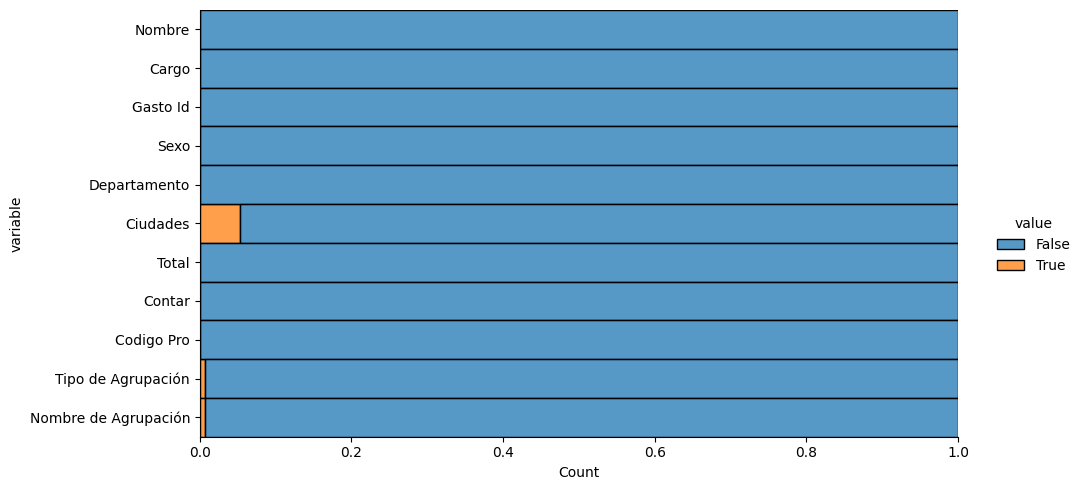

In [14]:
(
    gastos_df.isnull()
    .melt()
    .pipe(
        lambda df: (
            sns.displot(data=df, y="variable", hue="value", multiple="fill", aspect=2)
        )
    )
)

## Visualizacion de valores nulos


<Axes: >

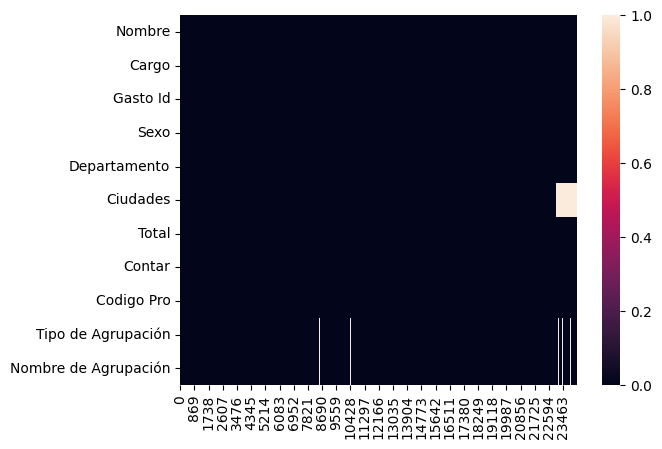

In [15]:
(
    gastos_df.isnull()
    .transpose()
    .pipe(
        lambda data: (
            sns.heatmap(
                data,
            )
        )
    )
)

# Conteo y proporciones


## Que estadisticos describen el conjunto de datos?


In [16]:
gastos_df.describe(include="all")

Nombre         Cargo      Gasto Id   Sexo  \
count                             24308         24308  24308.000000  24306   
unique                             5955             2           NaN      2   
top     juan_carlos_sarmiento_sarmiento  Alcaldia_fun           NaN      M   
freq                                 12         23039           NaN  20167   
mean                                NaN           NaN    205.206311    NaN   
std                                 NaN           NaN      2.807494    NaN   
min                                 NaN           NaN    201.000000    NaN   
25%                                 NaN           NaN    203.000000    NaN   
50%                                 NaN           NaN    205.000000    NaN   
75%                                 NaN           NaN    207.000000    NaN   
max                                 NaN           NaN    211.000000    NaN   

        Departamento Ciudades         Total        Contar  \
count          24308    23005  2.430800e+04  24308.000000   
unique            33     1019           NaN           NaN   
top     Cundinamarca  Granada           NaN           NaN   
freq            2909      116           NaN           NaN   
mean             NaN      NaN  2.014093e+07      5.478772   
std              NaN      NaN  1.726824e+08     12.598493   
min              NaN      NaN  0.000000e+00      1.000000   
25%              NaN      NaN  1.200000e+06      1.000000   
50%              NaN      NaN  4.600000e+06      2.000000   
75%              NaN      NaN  1.407650e+07      5.000000   
max              NaN      NaN  2.136100e+10    267.000000   

                                               Codigo Pro  \
count                                               24308   
unique                                                 11   
top     207 - Gastos judiciales y de rendición de cuentas   
freq                                                 4566   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

         Tipo de Agrupación            Nombre de Agrupación  
count                 24125                           24125  
unique                    3                            1838  
top     Agrupacion Politica  PARTIDO CONSERVADOR COLOMBIANO  
freq                  14245                            1262  
mean                    NaN                             NaN  
std                     NaN                             NaN  
min                     NaN                             NaN  
25%                     NaN                             NaN  
50%                     NaN                             NaN  
75%                     NaN                             NaN  
max                     NaN                             NaN

### Solo numericas


In [17]:
gastos_df.describe()

Gasto Id         Total        Contar
count  24308.000000  2.430800e+04  24308.000000
mean     205.206311  2.014093e+07      5.478772
std        2.807494  1.726824e+08     12.598493
min      201.000000  0.000000e+00      1.000000
25%      203.000000  1.200000e+06      1.000000
50%      205.000000  4.600000e+06      2.000000
75%      207.000000  1.407650e+07      5.000000
max      211.000000  2.136100e+10    267.000000

### Solo categoricas -1


In [18]:
gastos_df.describe(include=object)

Nombre         Cargo   Sexo  Departamento  \
count                             24308         24308  24306         24308   
unique                             5955             2      2            33   
top     juan_carlos_sarmiento_sarmiento  Alcaldia_fun      M  Cundinamarca   
freq                                 12         23039  20167          2909   

       Ciudades                                         Codigo Pro  \
count     23005                                              24308   
unique     1019                                                 11   
top     Granada  207 - Gastos judiciales y de rendición de cuentas   
freq        116                                               4566   

         Tipo de Agrupación            Nombre de Agrupación  
count                 24125                           24125  
unique                    3                            1838  
top     Agrupacion Politica  PARTIDO CONSERVADOR COLOMBIANO  
freq                  14245                            1262

### Columnas categoricas


c:\Users\SergioxD\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


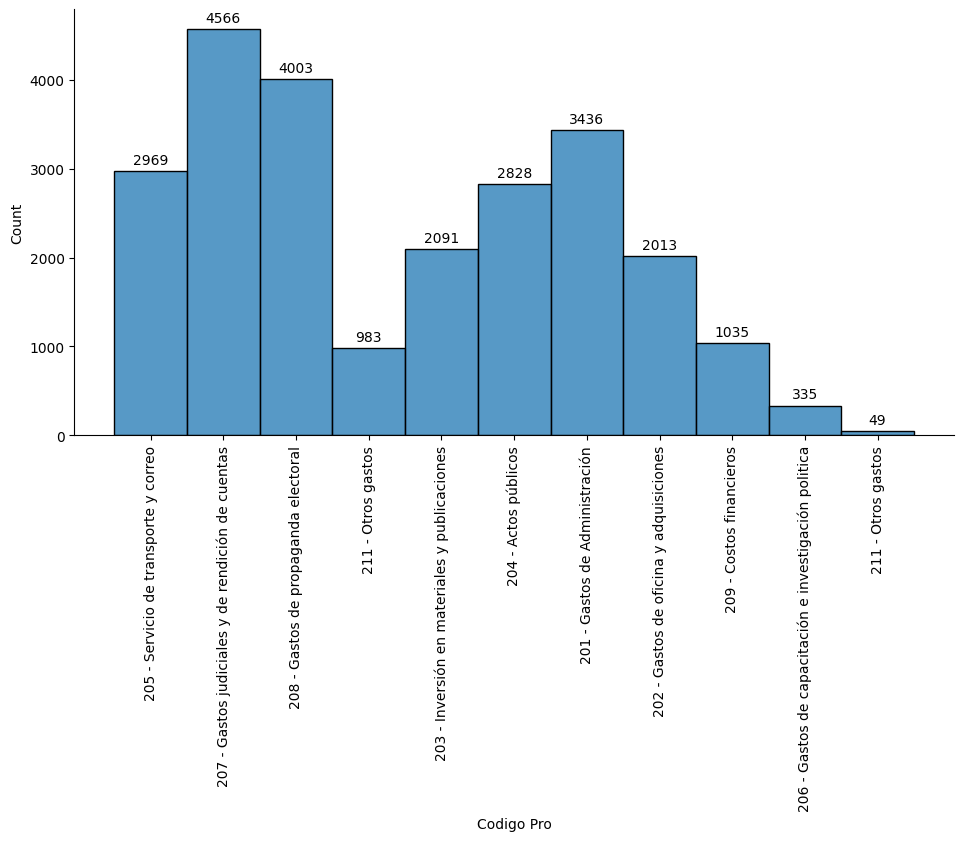

In [19]:
sns.displot(data=gastos_df, x="Codigo Pro", aspect=2)
plt.xticks(rotation=90)
autoLabel()
plt.show()

c:\Users\SergioxD\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


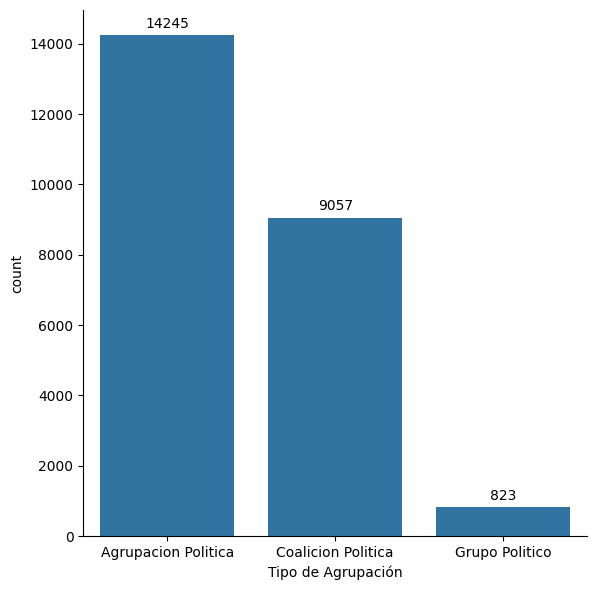

In [20]:
sns.catplot(
    x="Tipo de Agrupación",
    # col="Cargo",
    kind="count",
    height=6,
    aspect=1,
    data=gastos_df,
)


autoLabel()


plt.show()

c:\Users\SergioxD\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


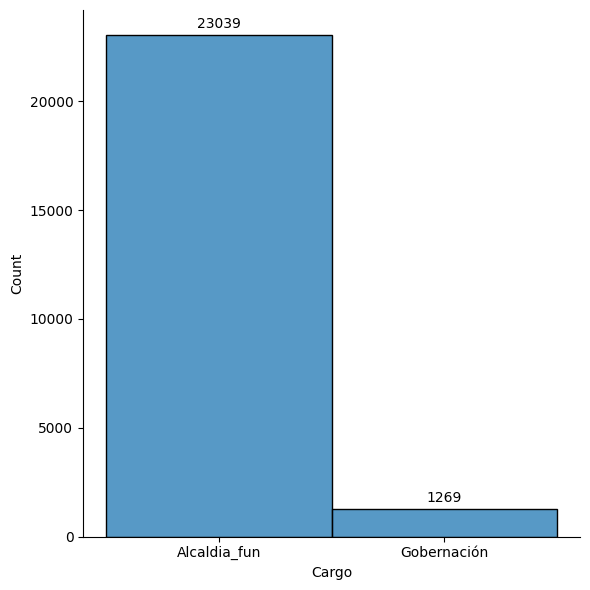

In [21]:
sns.displot(data=gastos_df, x="Cargo", height=6, aspect=1)
autoLabel()
plt.show()

## Normalizar datos de la columna Codigo Pro


In [22]:
gastos_df["Codigo Pro"].unique()

array(['205 - Servicio de transporte y correo',
       '207 - Gastos judiciales y de rendición de cuentas',
       '208 - Gastos de propaganda electoral', '211 - Otros gastos',
       '203 - Inversión en materiales y publicaciones',
       '204 - Actos públicos', '201 - Gastos de Administración',
       '202 - Gastos de oficina y adquisiciones',
       '209 - Costos financieros',
       '206 - Gastos de capacitación e investigación politica',
       '211 -\xa0Otros\xa0gastos'], dtype=object)

In [23]:
def normalizeCodigoPro(fila):
    codigo = fila["Codigo Pro"]
    if isinstance(codigo, str):
        if codigo.startswith("211"):
            return codigo.replace("\xa0", " ")
        else:
            return codigo
    else:
        return codigo


gastos_df["Codigo Pro"] = gastos_df.apply(normalizeCodigoPro, axis=1)
gastos_df["Codigo Pro"].unique()

array(['205 - Servicio de transporte y correo',
       '207 - Gastos judiciales y de rendición de cuentas',
       '208 - Gastos de propaganda electoral', '211 - Otros gastos',
       '203 - Inversión en materiales y publicaciones',
       '204 - Actos públicos', '201 - Gastos de Administración',
       '202 - Gastos de oficina y adquisiciones',
       '209 - Costos financieros',
       '206 - Gastos de capacitación e investigación politica'],
      dtype=object)

C:\Users\SergioxD\AppData\Local\Temp\ipykernel_23500\1987836465.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().xaxis.set_ticklabels(format_long_text)


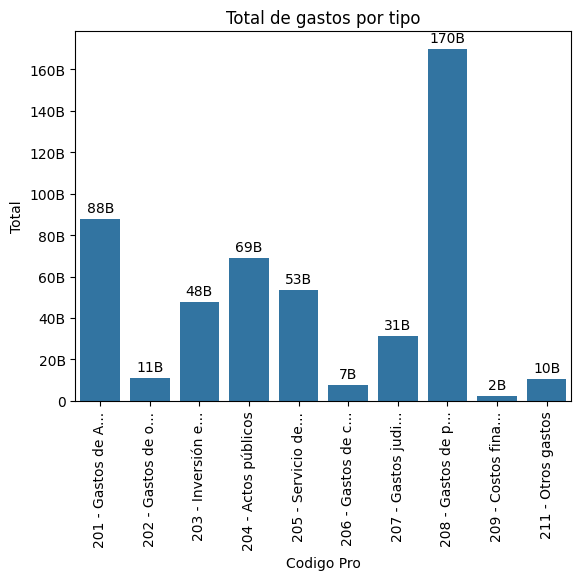

In [24]:
sns.barplot(
    x="Codigo Pro",
    y="Total",
    data=gastos_df.groupby("Codigo Pro")["Total"].sum().reset_index(),
)

def truncate_label(label, length=20):
    if len(label) > length:
        return label[: length - 3] + "..."
    else:
        return label


format_long_text = [
    truncate_label(l.get_text()) for l in plt.gca().xaxis.get_ticklabels()
]
plt.title("Total de gastos por tipo")
plt.xticks(rotation=90)
plt.gca().xaxis.set_ticklabels(format_long_text)

plt.gca().yaxis.set_major_formatter(func_form_millon_billon)
autoLabel()
plt.show()

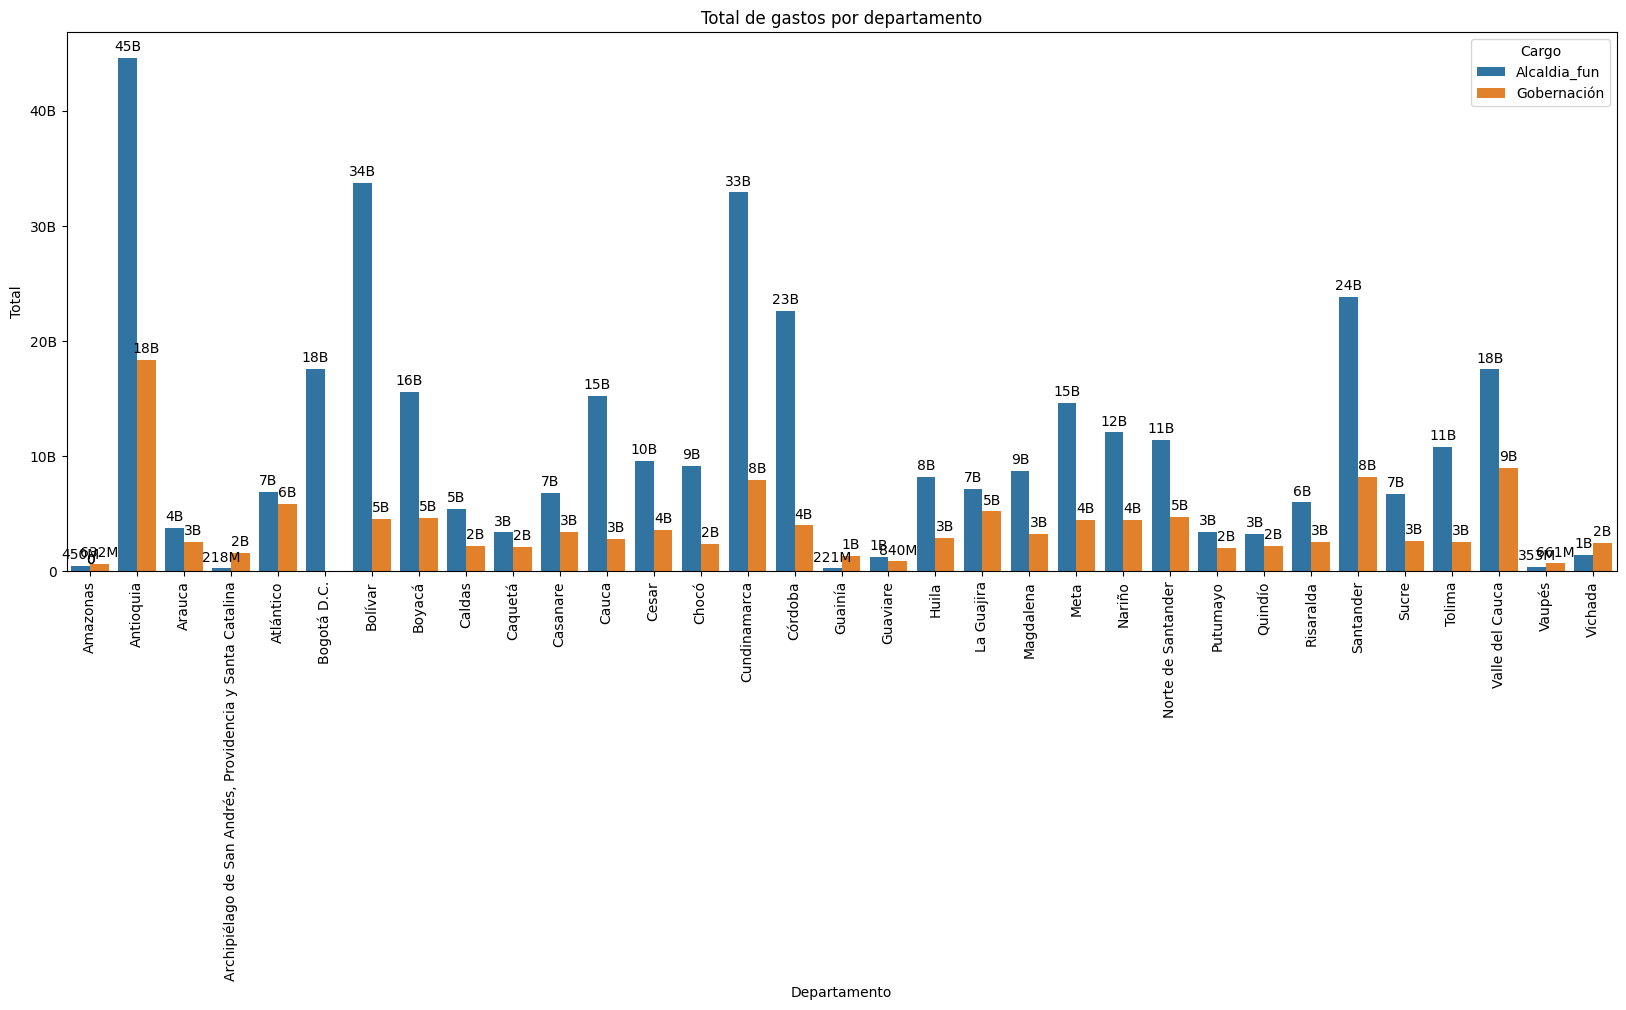

In [25]:
# sns.displot(x="Departamento", y="Total",kind='kde',height=8, aspect=1, data=gastos_df)

plt.figure(figsize=(20, 7))
sns.barplot(
    x="Departamento",
    y="Total",
    hue="Cargo",
    # dodge=False,
    data=gastos_df.groupby(["Departamento", "Cargo"])["Total"].sum().reset_index(),
    # aspect=2
)


plt.title("Total de gastos por departamento")
plt.xticks(rotation=90)
# plt.gca().xaxis.set_ticklabels(format_long_text)
plt.gca().yaxis.set_major_formatter(func_form_millon_billon)
autoLabel()

plt.show()

c:\Users\SergioxD\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


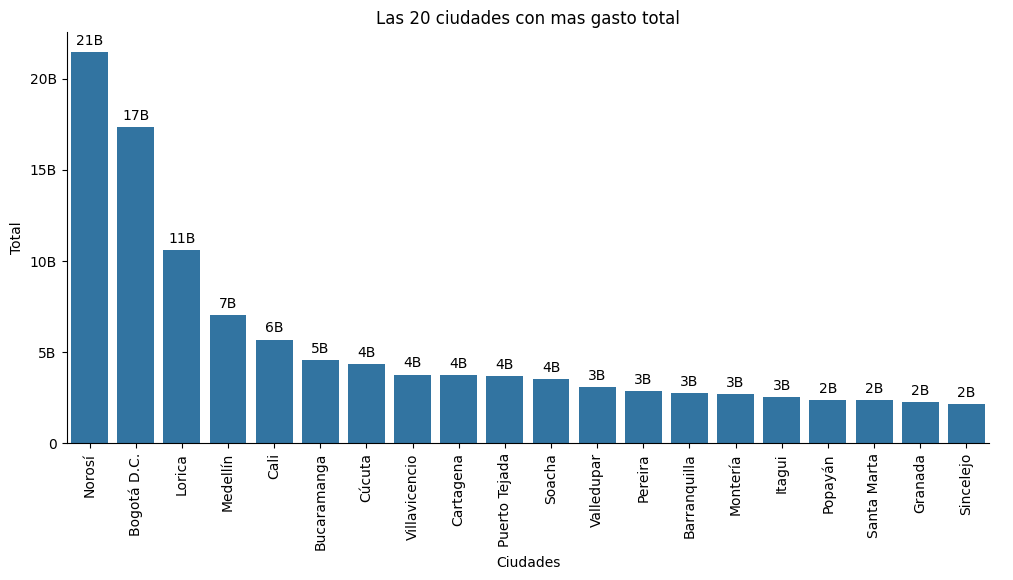

In [26]:
# Calcular la suma del Total por Nombre de Agrupación y Tipo de Agrupación
grouoped_data = gastos_df.groupby("Ciudades")["Total"].sum().reset_index()

# Filtrar los primeros 10 resultados
df_top_10 = grouoped_data.nlargest(20, "Total")

# Luego, puedes usar seaborn para trazar un catplot
sns.catplot(
    x="Ciudades",
    y="Total",
    # hue="Tipo de Agrupación",
    kind="bar",
    data=df_top_10,
    aspect=2,
)
plt.title("Las 20 ciudades con mas gasto total")

plt.xticks(rotation=90)
plt.gca().yaxis.set_major_formatter(func_form_millon_billon)
autoLabel()
plt.show()

In [27]:
len(gastos_df["Nombre de Agrupación"].unique())

1839

c:\Users\SergioxD\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\SergioxD\AppData\Local\Temp\ipykernel_23500\2291533764.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().xaxis.set_ticklabels(format_long_text)


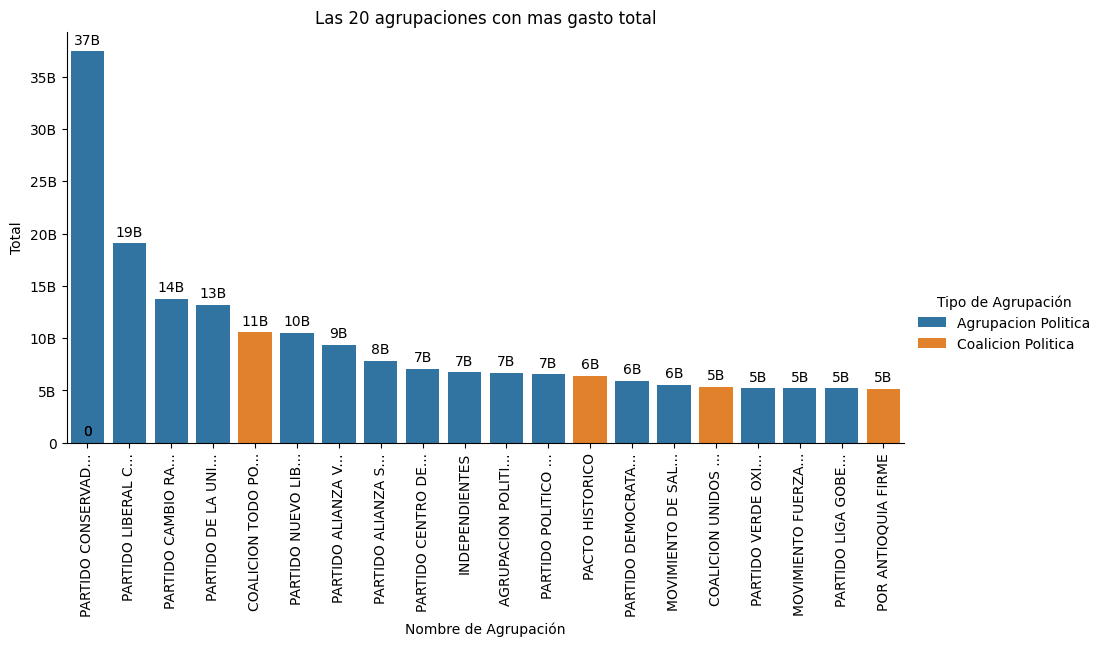

In [28]:
# Calcular la suma del Total por Nombre de Agrupación y Tipo de Agrupación
grouoped_data = (
    gastos_df.groupby(["Nombre de Agrupación", "Tipo de Agrupación"])["Total"]
    .sum()
    .reset_index()
)

# Filtrar los primeros 10 resultados
df_top_10 = grouoped_data.nlargest(20, "Total")

# Luego, puedes usar seaborn para trazar un catplot
sns.catplot(
    x="Nombre de Agrupación",
    y="Total",
    hue="Tipo de Agrupación",
    kind="bar",
    data=df_top_10,
    aspect=2,
)
plt.title("Las 20 agrupaciones con mas gasto total")
format_long_text = [
    truncate_label(l.get_text()) for l in plt.gca().xaxis.get_ticklabels()
]
plt.xticks(rotation=90)
plt.gca().xaxis.set_ticklabels(format_long_text)
plt.gca().yaxis.set_major_formatter(func_form_millon_billon)
autoLabel()
plt.show()

c:\Users\SergioxD\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


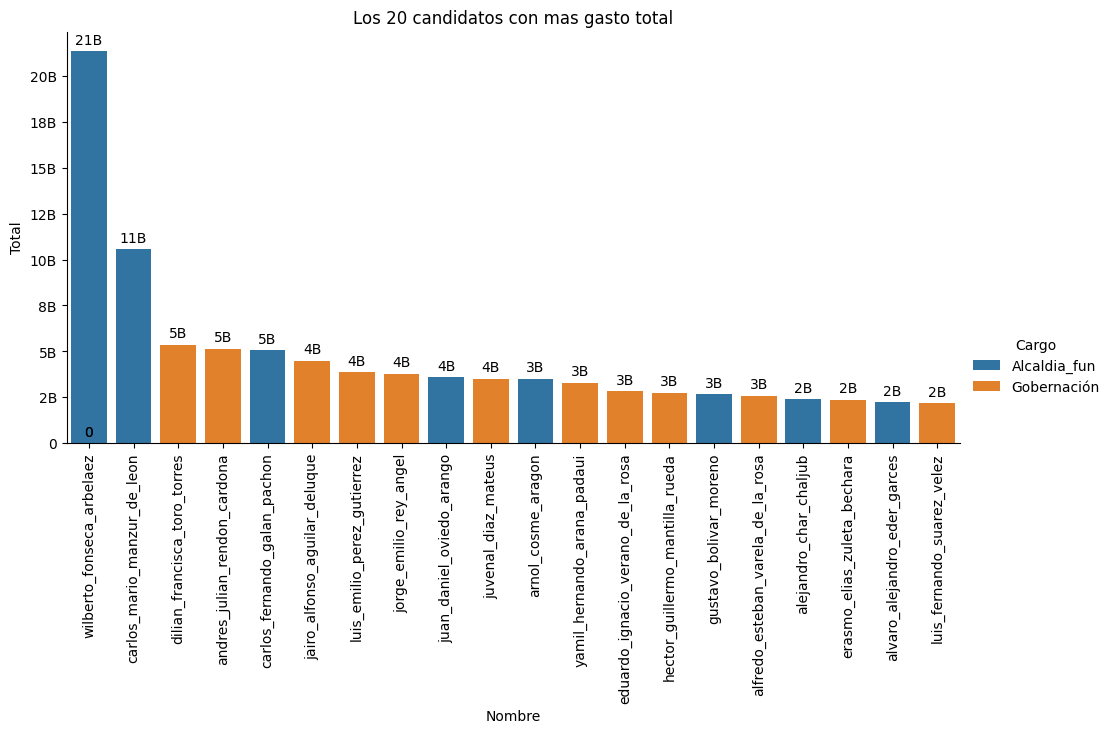

In [29]:
# Calcular la suma del Total por Nombre de Agrupación y Tipo de Agrupación
grouoped_data = gastos_df.groupby(["Nombre", "Cargo"])["Total"].sum().reset_index()

# Filtrar los primeros 10 resultados
df_top_10 = grouoped_data.nlargest(20, "Total")

# Luego, puedes usar seaborn para trazar un catplot
sns.catplot(x="Nombre", y="Total", hue="Cargo", kind="bar", data=df_top_10, aspect=2)
plt.title("Los 20 candidatos con mas gasto total")

plt.xticks(rotation=90)
plt.gca().yaxis.set_major_formatter(func_form_millon_billon)
autoLabel()
plt.show()

In [30]:
gastos_df["Departamento"].unique()

array(['Antioquia', 'Bolívar', 'Nariño', 'Atlántico', 'Putumayo',
       'Caldas', 'Magdalena', 'Santander', 'Córdoba', 'Huila', 'Tolima',
       'Meta', 'Chocó', 'Valle del Cauca', 'Cundinamarca', 'Boyacá',
       'Cesar', 'Sucre', 'Cauca', 'Norte de Santander', 'Vichada',
       'Casanare', 'La Guajira', 'Risaralda',
       'Archipiélago de San Andrés, Providencia y Santa Catalina',
       'Quindío', 'Caquetá', 'Arauca', 'Amazonas', 'Guainía',
       'Bogotá D.C.', 'Vaupés', 'Guaviare'], dtype=object)

In [31]:
gastos_df["Cargo"].unique()

array(['Alcaldia_fun', 'Gobernación'], dtype=object)

c:\Users\SergioxD\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


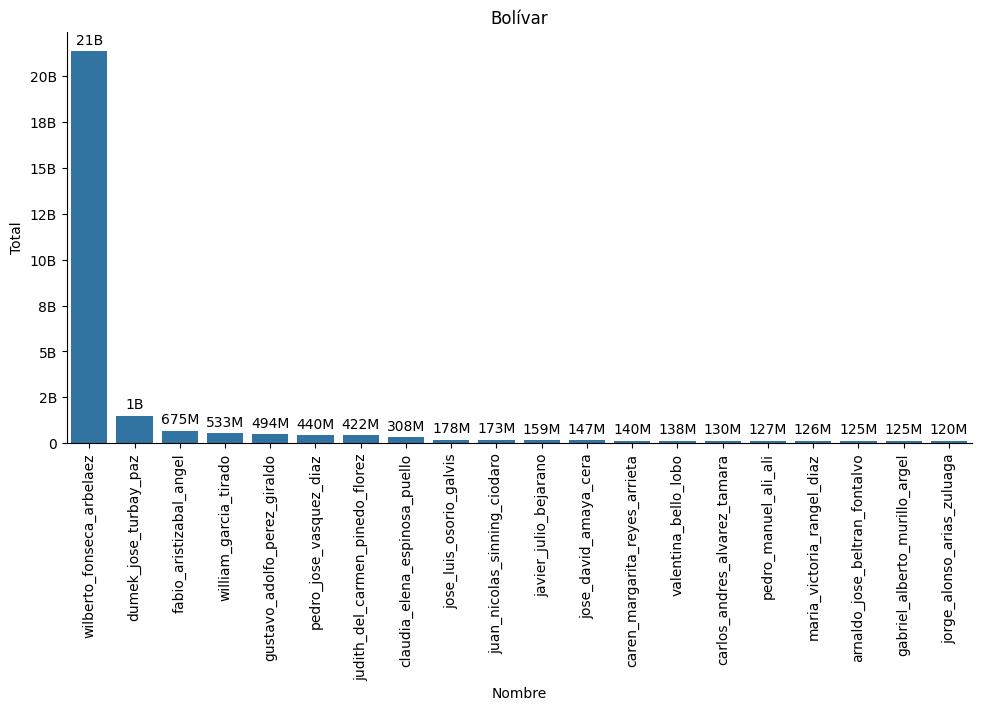

In [32]:
# Luego, puedes usar seaborn para trazar un catplot
departamento = "Bolívar"
cargo = "Alcaldia_fun"
gastos_departamento_df = gastos_df[
    (gastos_df["Departamento"] == departamento) & (gastos_df["Cargo"] == cargo)
]

# Calcular la suma del Total por Nombre de Agrupación y Tipo de Agrupación
grouoped_data = (
    gastos_departamento_df.groupby(["Nombre", "Cargo"])["Total"].sum().reset_index()
)

# Filtrar los primeros 10 resultados
df_top_10 = grouoped_data.nlargest(20, "Total")


sns.catplot(
    x="Nombre",
    y="Total",
    # hue="Cargo",
    kind="bar",
    data=df_top_10,
    aspect=2,
)
plt.title(departamento)

plt.xticks(rotation=90)
plt.gca().yaxis.set_major_formatter(func_form_millon_billon)
autoLabel()
plt.show()

c:\Users\SergioxD\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\SergioxD\AppData\Local\Temp\ipykernel_23500\2868225857.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().xaxis.set_ticklabels(format_long_text)


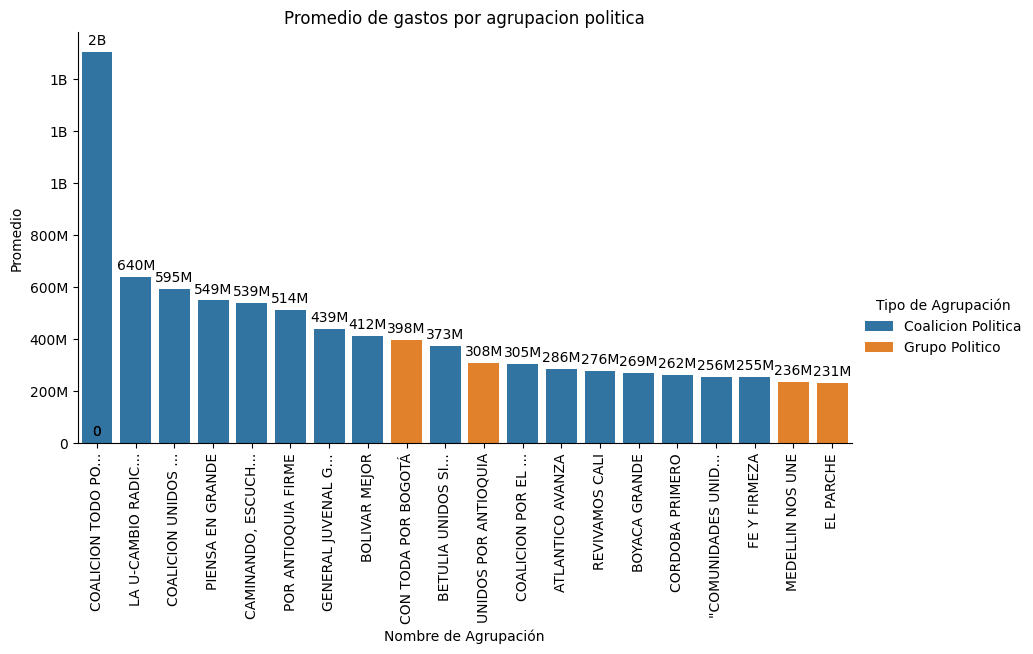

In [33]:
# Calcular la suma del Total por Nombre de Agrupación y Tipo de Agrupación
grouoped_data = gastos_df.groupby(["Nombre de Agrupación", "Tipo de Agrupación"])


agg_data = grouoped_data.agg(Promedio=pd.NamedAgg(column="Total", aggfunc="mean"))
# Filtrar los primeros 10 resultados
df_top_10 = agg_data.nlargest(20, "Promedio")
sns.catplot(
    x="Nombre de Agrupación",
    y="Promedio",
    hue="Tipo de Agrupación",
    kind="bar",
    data=df_top_10,
    aspect=2,
)
plt.title("Promedio de gastos por agrupacion politica")
format_long_text = [
    truncate_label(l.get_text()) for l in plt.gca().xaxis.get_ticklabels()
]
plt.xticks(rotation=90)
plt.gca().xaxis.set_ticklabels(format_long_text)
plt.gca().yaxis.set_major_formatter(func_form_millon_billon)
autoLabel()
plt.show()

c:\Users\SergioxD\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\SergioxD\AppData\Local\Temp\ipykernel_23500\1394198019.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().xaxis.set_ticklabels(format_long_text)


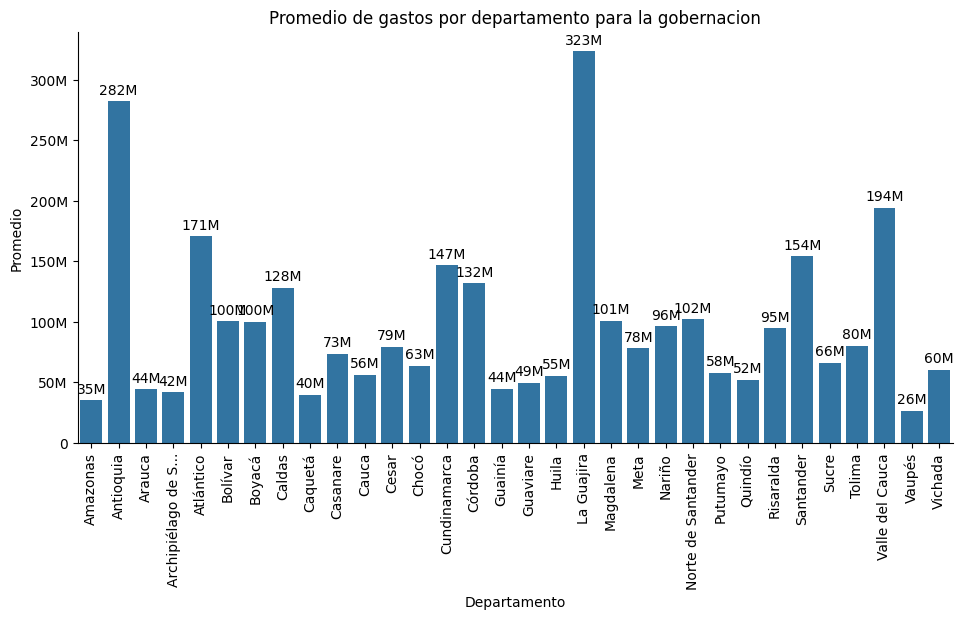

In [34]:
# Calcular la suma del Total por departamento

cargo = "Gobernación"
gastos_departamento_df = gastos_df[(gastos_df["Cargo"] == cargo)]
grouped_data = gastos_departamento_df.groupby(["Departamento"])

agg_data = grouped_data.agg(Promedio=pd.NamedAgg(column="Total", aggfunc="mean"))
# Filtrar los primeros 10 resultados
# df_top_10 = agg_data.nlargest(20, "Promedio")
sns.catplot(
    x="Departamento",
    y="Promedio",
    # hue="Cargo",
    kind="bar",
    data=agg_data,
    aspect=2,
)
plt.title("Promedio de gastos por departamento para la gobernacion")

plt.xticks(rotation=90)
format_long_text = [
    truncate_label(l.get_text()) for l in plt.gca().xaxis.get_ticklabels()
]
plt.gca().xaxis.set_ticklabels(format_long_text)
plt.gca().yaxis.set_major_formatter(func_form_millon_billon)
autoLabel()
plt.show()

c:\Users\SergioxD\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


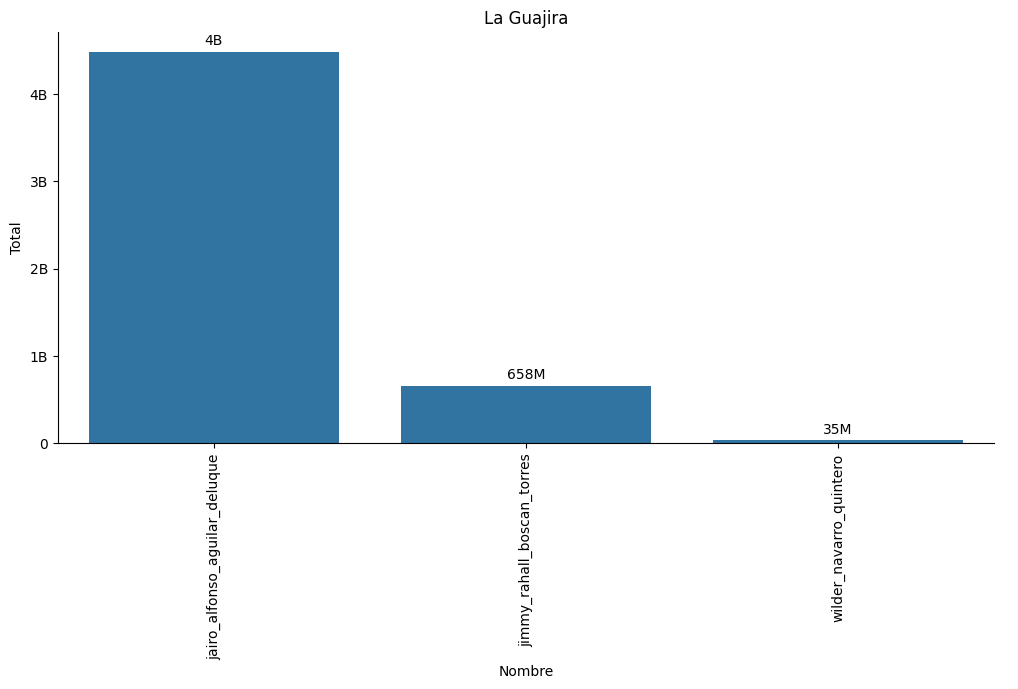

In [56]:
# Luego, puedes usar seaborn para trazar un catplot
departamento = "La Guajira"
cargo = "Gobernación"
gastos_departamento_df = gastos_df[
    (gastos_df["Departamento"] == departamento) & (gastos_df["Cargo"] == cargo)
]

# Calcular la suma del Total por Nombre de Agrupación y Tipo de Agrupación
grouoped_data = (
    gastos_departamento_df.groupby(["Nombre", "Cargo"])["Total"].sum().reset_index()
)

# Filtrar los primeros 10 resultados
df_top_10 = grouoped_data.nlargest(20, "Total")


sns.catplot(
    x="Nombre",
    y="Total",
    # hue="Cargo",
    kind="bar",
    data=df_top_10,
    aspect=2,
)
plt.title(departamento)

plt.xticks(rotation=90)
plt.gca().yaxis.set_major_formatter(func_form_millon_billon)
autoLabel()
plt.show()

c:\Users\SergioxD\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\SergioxD\AppData\Local\Temp\ipykernel_23500\1486296068.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().xaxis.set_ticklabels(format_long_text)


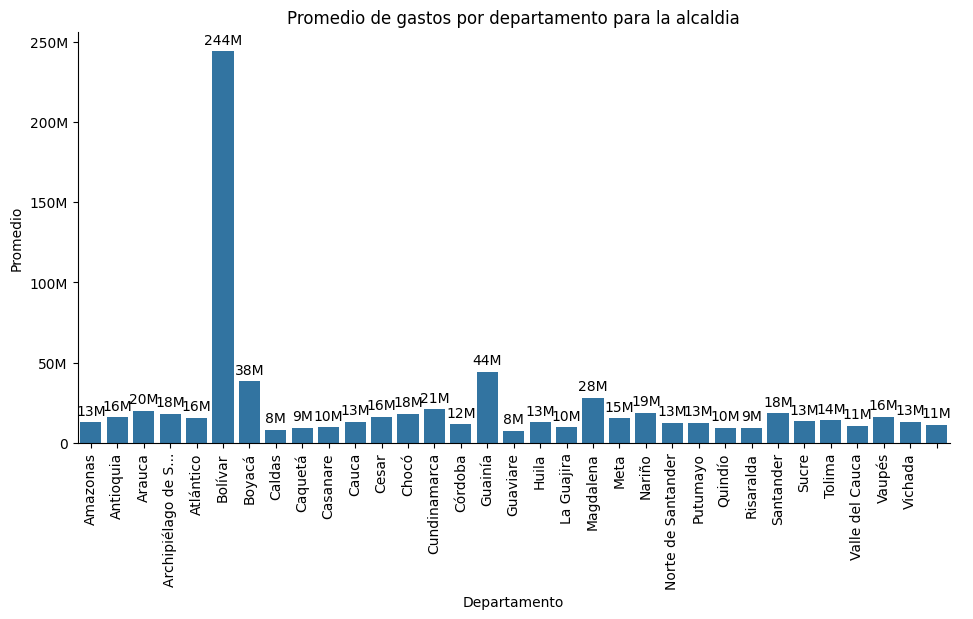

In [35]:
# Calcular la suma del Total por departamento

cargo = "Alcaldia_fun"
gastos_departamento_df = gastos_df[(gastos_df["Cargo"] == cargo)]
grouped_data = gastos_departamento_df.groupby(["Departamento"])

agg_data = grouped_data.agg(Promedio=pd.NamedAgg(column="Total", aggfunc="mean"))
# Filtrar los primeros 10 resultados
# df_top_10 = agg_data.nlargest(20, "Promedio")
sns.catplot(
    x="Departamento",
    y="Promedio",
    # hue="Cargo",
    kind="bar",
    data=agg_data,
    aspect=2,
)
plt.title("Promedio de gastos por departamento para la alcaldia")

plt.xticks(rotation=90)
plt.gca().xaxis.set_ticklabels(format_long_text)
plt.gca().yaxis.set_major_formatter(func_form_millon_billon)
autoLabel()
plt.show()

In [36]:
# Calcular la suma del Total por departamento

cargo = "Alcaldia_fun"
gastos_departamento_df = gastos_df[(gastos_df["Cargo"] == cargo)]
grouped_data = gastos_departamento_df.groupby(["Ciudades"])


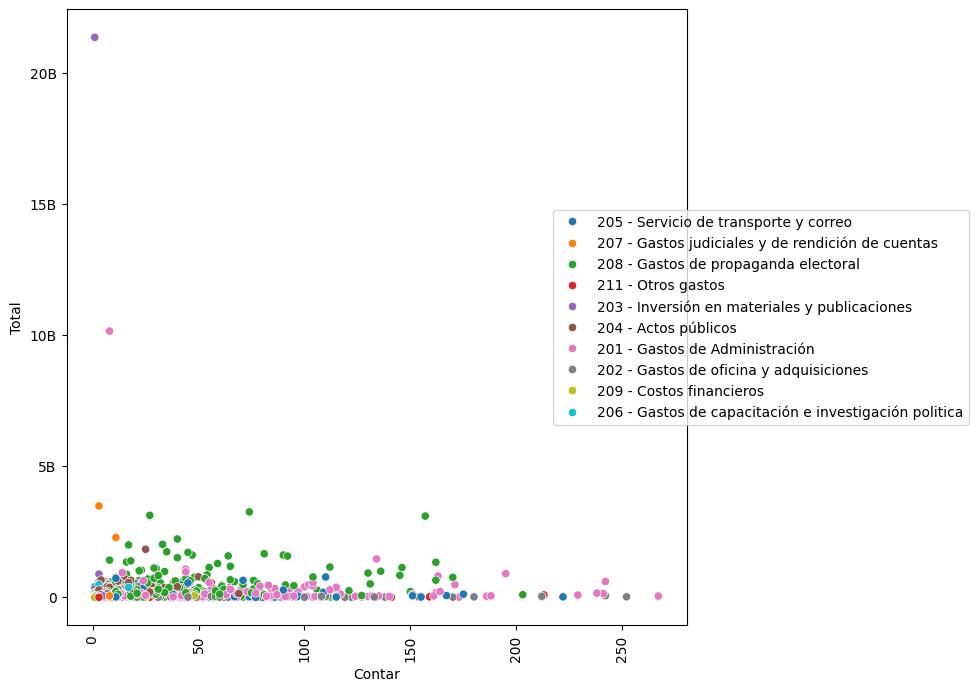

In [37]:
plt.figure(figsize=(8, 8))
sns.scatterplot(data=gastos_df, x="Contar", y="Total", hue="Codigo Pro")
plt.legend(loc="center", bbox_to_anchor=(1.12, 0.5))
plt.xticks(rotation=90)
plt.gca().yaxis.set_major_formatter(func_form_millon_billon)
autoLabel()
plt.show()

c:\Users\SergioxD\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


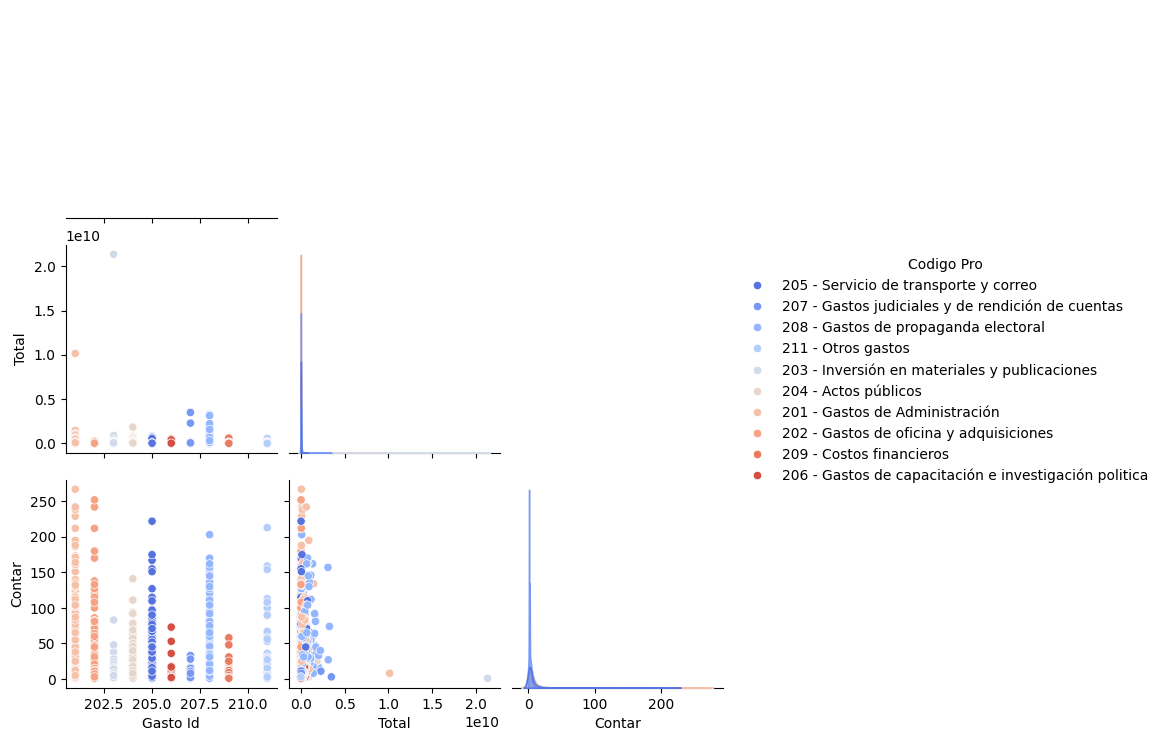

In [38]:
sns.pairplot(
    data=gastos_df, hue="Codigo Pro", palette="coolwarm", corner=True, kind="scatter"
)
plt.show()

## Cada tipo de gasto a columna

In [39]:
gastos_df["Ciudades"].fillna("Desconocido", inplace=True)

gastos_df_i2 = gastos_df.pivot_table(
    index=[
        "Nombre",
        "Cargo",
        "Sexo",
        "Departamento",
        "Ciudades",
        "Contar",
        "Tipo de Agrupación",
        "Nombre de Agrupación",
    ],
    columns="Codigo Pro",
    values="Total",
    aggfunc="sum",
    # dropna=False,
    # fill_value=0,
)

gastos_df_i2 = gastos_df_i2.reset_index()

gastos_df_i2.columns.name = None

gastos_df_i2 = gastos_df_i2.groupby(
    [
        "Nombre",
        "Cargo",
        "Sexo",
        "Departamento",
        "Ciudades",
        "Tipo de Agrupación",
        "Nombre de Agrupación",
    ],
    as_index=False,
).agg(
    {
        "Contar": "sum",
        "201 - Gastos de Administración": "sum",
        "202 - Gastos de oficina y adquisiciones": "sum",
        "203 - Inversión en materiales y publicaciones": "sum",
        "204 - Actos públicos": "sum",
        "205 - Servicio de transporte y correo": "sum",
        "206 - Gastos de capacitación e investigación politica": "sum",
        "207 - Gastos judiciales y de rendición de cuentas": "sum",
        "208 - Gastos de propaganda electoral": "sum",
        "209 - Costos financieros": "sum",
        "211 - Otros gastos": "sum",
    }
)
gastos_df_i2.shape

(5916, 18)

In [40]:

gastos_df_i2["Nombre"].unique().size

5912

## Agregar columna Total de gasto

In [41]:
# Crear la columna Total de Gastos
gasto_columns = [
    '201 - Gastos de Administración',
    '202 - Gastos de oficina y adquisiciones',
    '203 - Inversión en materiales y publicaciones',
    '204 - Actos públicos',
    '205 - Servicio de transporte y correo',
    '206 - Gastos de capacitación e investigación politica',
    '207 - Gastos judiciales y de rendición de cuentas',
    '208 - Gastos de propaganda electoral',
    '209 - Costos financieros',
    '211 - Otros gastos'
]

gastos_df_i2['Total de Gastos'] = gastos_df_i2[gasto_columns].sum(axis=1)
gastos_df_i2

Nombre         Cargo Sexo Departamento  \
0               abad_de_jesus_marin_arcila  Alcaldia_fun    M    Antioquia   
1               abel_alberto_polanco_lemos  Alcaldia_fun    M      Bolívar   
2               abel_angel_quiñones_urbano  Alcaldia_fun    M       Nariño   
3               abel_antonio_cepeda_macias  Alcaldia_fun    M    Atlántico   
4            abel_antonio_paternina_orozco  Alcaldia_fun    M      Bolívar   
...                                    ...           ...  ...          ...   
5911      zamir_eduardo_castellanos_cortes  Alcaldia_fun    M       Boyacá   
5912                   zamir_sotelo_monroy  Alcaldia_fun    M       Boyacá   
5913          zamira_sofia_palis_fernandez  Alcaldia_fun    F        Sucre   
5914  zulay_slendy_leonor_mendez_gualteros  Alcaldia_fun    F         Meta   
5915  zuleivis_del_carmen_coronel_cantillo  Alcaldia_fun    F      Bolívar   

           Ciudades   Tipo de Agrupación  \
0        San Rafael  Agrupacion Politica   
1          Tiquisio  Agrupacion Politica   
2          Ricaurte  Agrupacion Politica   
3       Sabanalarga  Agrupacion Politica   
4       Arroyohondo   Coalicion Politica   
...             ...                  ...   
5911         Caldas  Agrupacion Politica   
5912         Saboyá   Coalicion Politica   
5913         Chalán  Agrupacion Politica   
5914  Puerto Gaitán  Agrupacion Politica   
5915    Arroyohondo  Agrupacion Politica   

                                   Nombre de Agrupación  Contar  \
0                           PARTIDO COLOMBIA RENACIENTE       4   
1                             PARTIDO NUEVO LIBERALISMO      19   
2     MOVIMIENTO AUTORIDADES INDIGENAS DE COLOMBIA "...       6   
3                          PARTIDO DEMOCRATA COLOMBIANO      15   
4                    NUEVO LIBERALISMO - CAMBIO RADICAL       1   
...                                                 ...     ...   
5911                          PARTIDO NUEVO LIBERALISMO       2   
5912                          SABOYA CRECE CON EL CAMPO       3   
5913         PARTIDO ALIANZA SOCIAL INDEPENDIENTE "ASI"       3   
5914                       PARTIDO DEMOCRATA COLOMBIANO       8   
5915                         PARTIDO LIBERAL COLOMBIANO       4   

      201 - Gastos de Administración  202 - Gastos de oficina y adquisiciones  \
0                                0.0                                     0.00   
1                                0.0                                     0.00   
2                          6300000.0                                     0.00   
3                                0.0                                     0.00   
4                                0.0                                     0.00   
...                              ...                                      ...   
5911                             0.0                                     0.00   
5912                             0.0                               7895000.00   
5913                             0.0                                     0.00   
5914                      10253200.0                               1458398.46   
5915                       3480000.0                               1200000.00   

      203 - Inversión en materiales y publicaciones  204 - Actos públicos  \
0                                               0.0                   0.0   
1                                         3000000.0            13700000.0   
2                                               0.0                   0.0   
3                                         4800000.0                   0.0   
4                                               0.0                   0.0   
...                                             ...                   ...   
5911                                      6270000.0                   0.0   
5912                                            0.0                   0.0   
5913                                            0.0                   0.0   
5914                  

In [42]:
gastos_df_i2.columns

Index(['Nombre', 'Cargo', 'Sexo', 'Departamento', 'Ciudades',
       'Tipo de Agrupación', 'Nombre de Agrupación', 'Contar',
       '201 - Gastos de Administración',
       '202 - Gastos de oficina y adquisiciones',
       '203 - Inversión en materiales y publicaciones', '204 - Actos públicos',
       '205 - Servicio de transporte y correo',
       '206 - Gastos de capacitación e investigación politica',
       '207 - Gastos judiciales y de rendición de cuentas',
       '208 - Gastos de propaganda electoral', '209 - Costos financieros',
       '211 - Otros gastos', 'Total de Gastos'],
      dtype='object')

## Que tipo de datos son las variables del conjunto de datos?

In [43]:
gastos_df_i2.dtypes

Nombre                                                    object
Cargo                                                     object
Sexo                                                      object
Departamento                                              object
Ciudades                                                  object
Tipo de Agrupación                                        object
Nombre de Agrupación                                      object
Contar                                                     int64
201 - Gastos de Administración                           float64
202 - Gastos de oficina y adquisiciones                  float64
203 - Inversión en materiales y publicaciones            float64
204 - Actos públicos                                     float64
205 - Servicio de transporte y correo                    float64
206 - Gastos de capacitación e investigación politica    float64
207 - Gastos judiciales y de rendición de cuentas        float64
208 - Gastos de propagand

In [44]:
(gastos_df_i2.dtypes.value_counts())

float64    11
object      7
int64       1
Name: count, dtype: int64

In [45]:
gastos_df_i2.shape

(5916, 19)

In [46]:
(gastos_df_i2.isnull().any())

Nombre                                                   False
Cargo                                                    False
Sexo                                                     False
Departamento                                             False
Ciudades                                                 False
Tipo de Agrupación                                       False
Nombre de Agrupación                                     False
Contar                                                   False
201 - Gastos de Administración                           False
202 - Gastos de oficina y adquisiciones                  False
203 - Inversión en materiales y publicaciones            False
204 - Actos públicos                                     False
205 - Servicio de transporte y correo                    False
206 - Gastos de capacitación e investigación politica    False
207 - Gastos judiciales y de rendición de cuentas        False
208 - Gastos de propaganda electoral                   

c:\Users\SergioxD\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


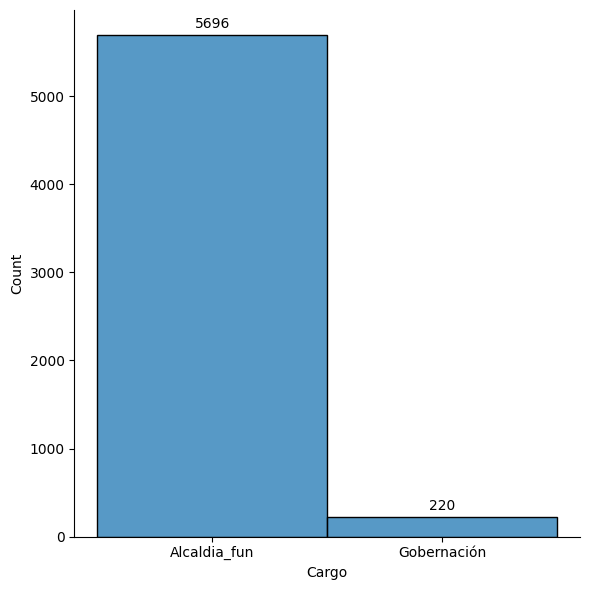

In [47]:
sns.displot(data=gastos_df_i2, x="Cargo", height=6, aspect=1)
autoLabel()
plt.show()

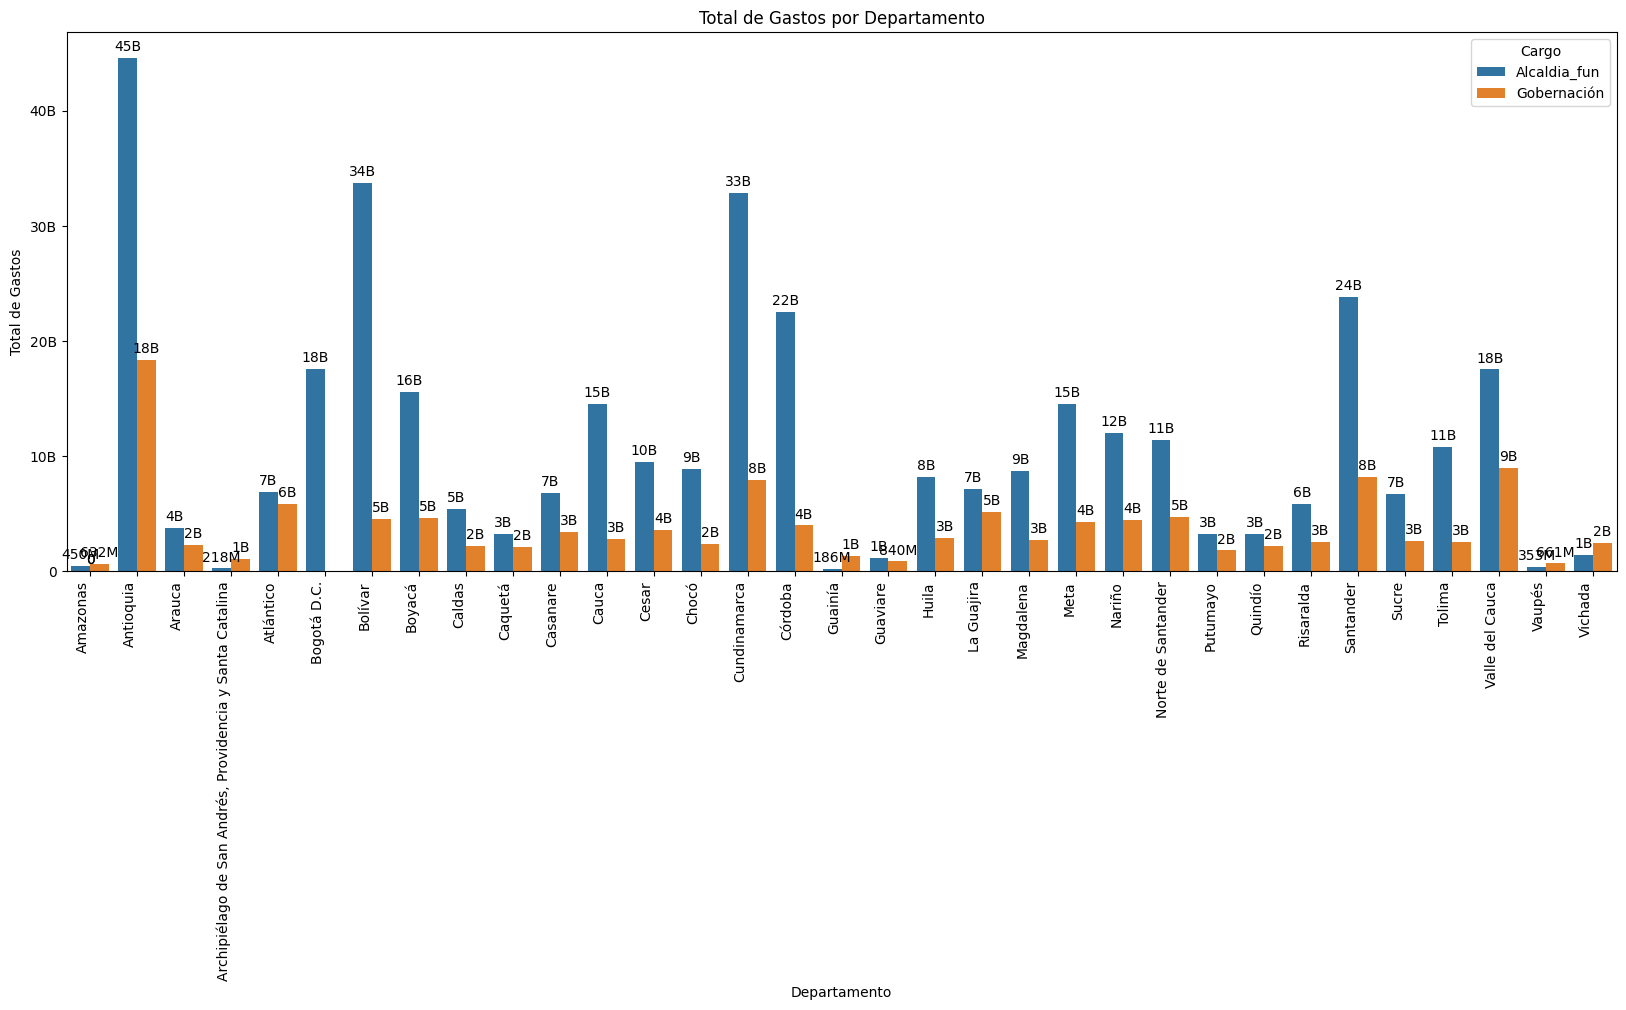

In [48]:

plt.figure(figsize=(20, 7))
sns.barplot(x="Departamento", y="Total de Gastos", hue="Cargo", data=gastos_df_i2.groupby(["Departamento", "Cargo"])["Total de Gastos"].sum().reset_index())
plt.xticks(rotation=90,ha='right')
plt.gca().yaxis.set_major_formatter(func_form_millon_billon)
autoLabel()
plt.title("Total de Gastos por Departamento")
plt.show()

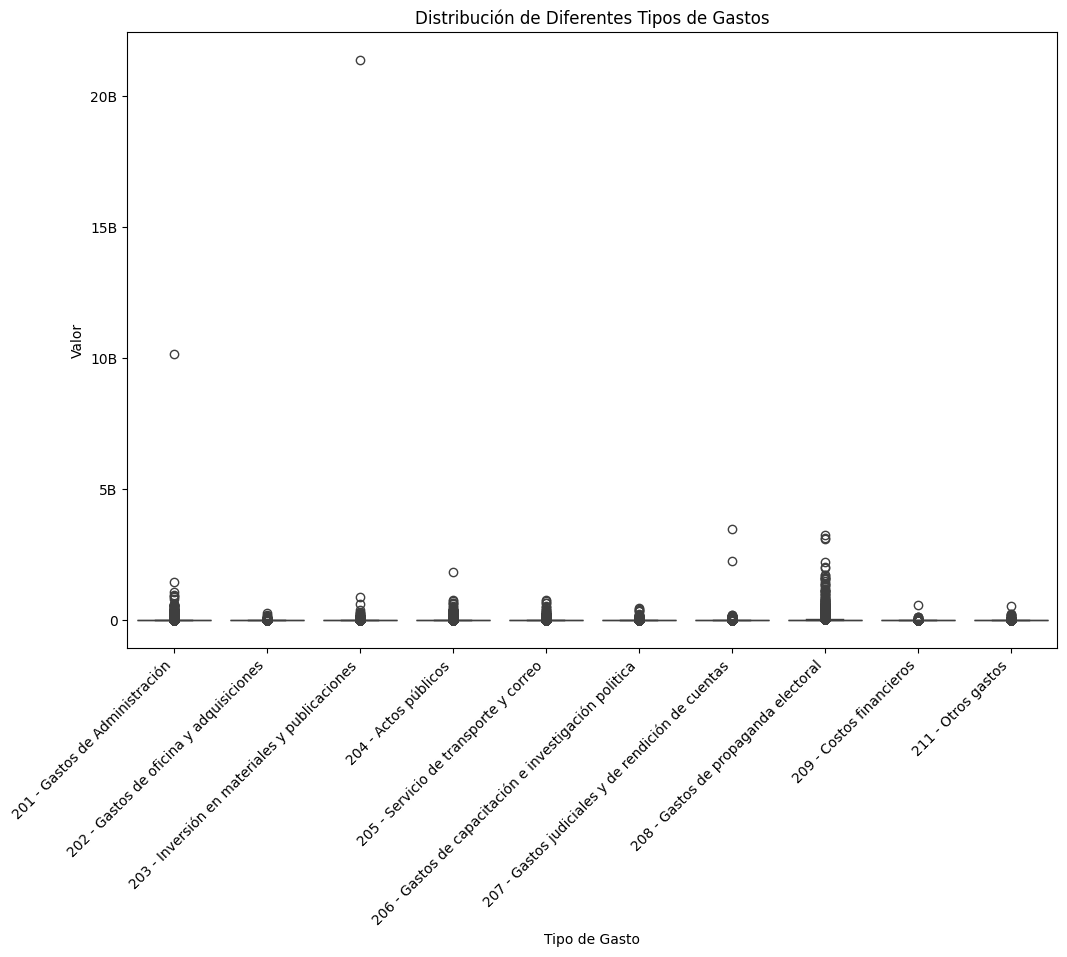

In [49]:
plt.figure(figsize=(12, 8))
df_melted = gastos_df_i2.melt(id_vars=['Sexo'], value_vars=gasto_columns, var_name='Tipo de Gasto', value_name='Valor')
sns.boxplot(x='Tipo de Gasto', y='Valor', data=df_melted)
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_formatter(func_form_millon_billon)
plt.title('Distribución de Diferentes Tipos de Gastos')
plt.show()

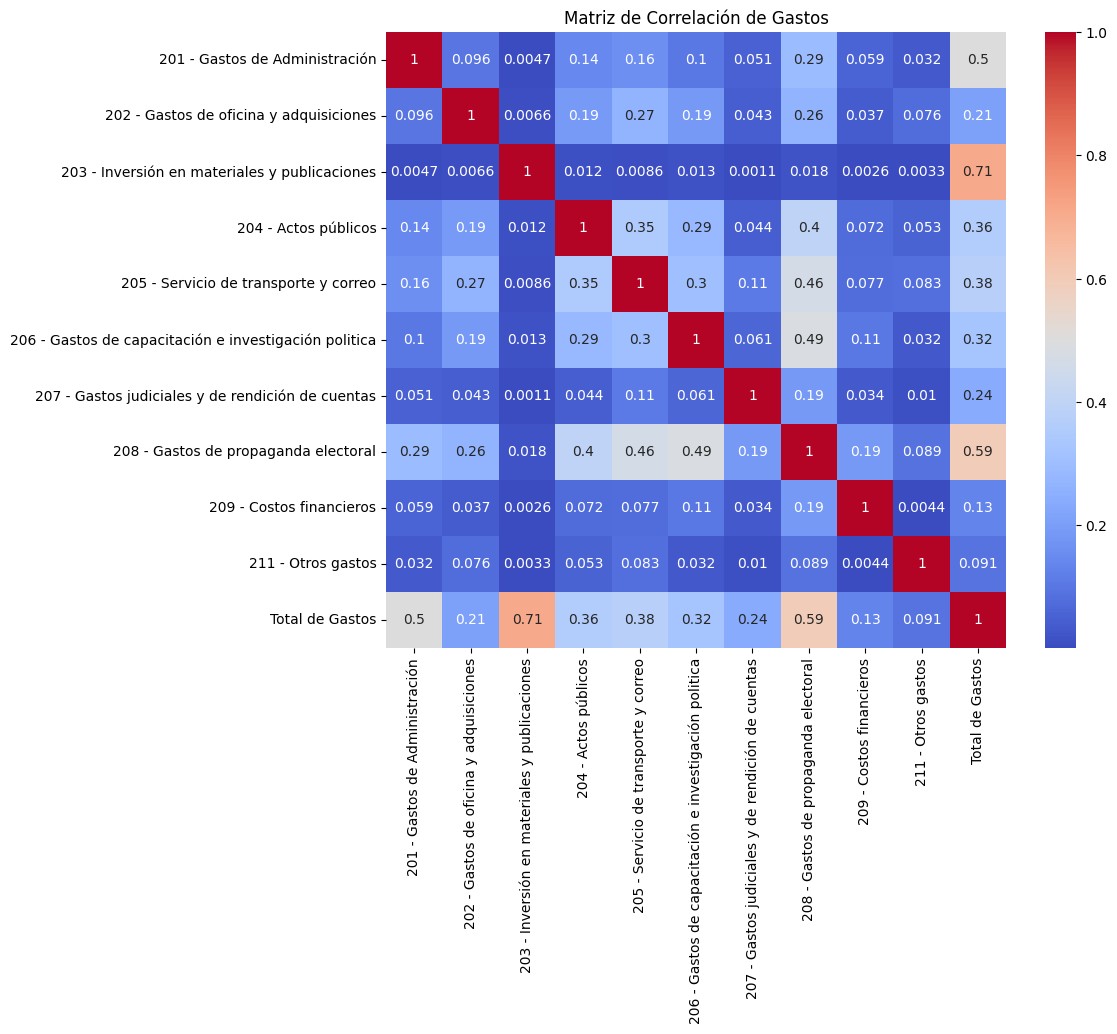

In [50]:
plt.figure(figsize=(10, 8))
corr = gastos_df_i2[gasto_columns + ['Total de Gastos']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación de Gastos')
plt.show()

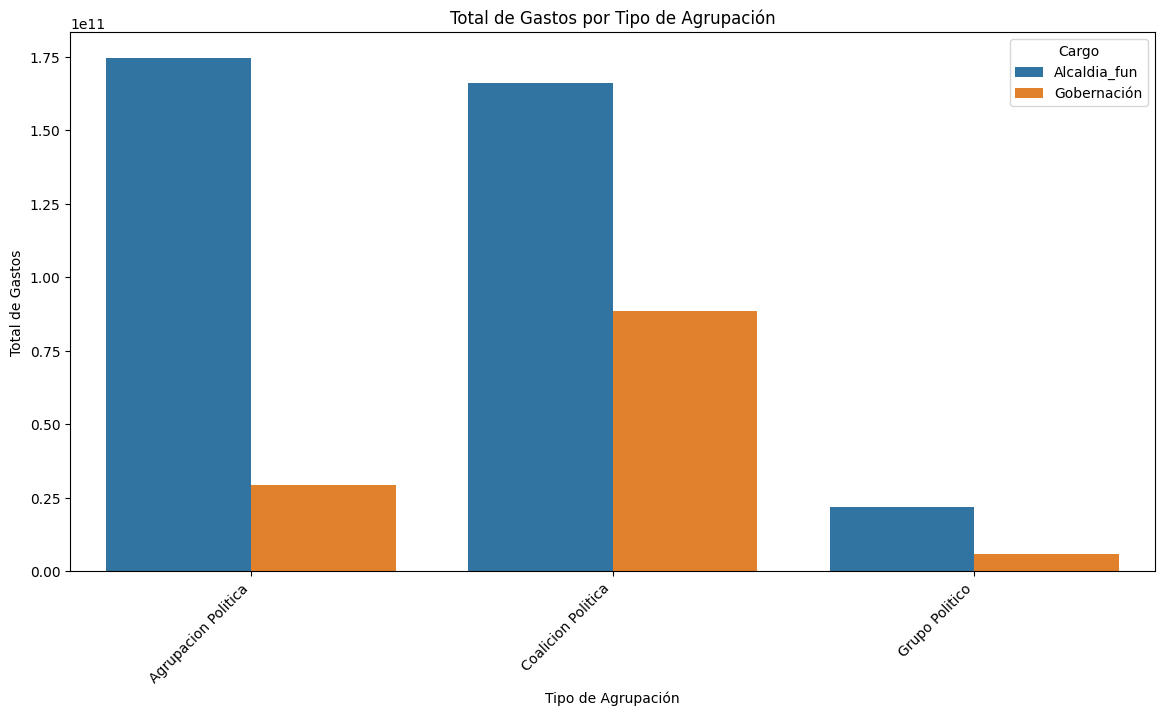

In [51]:
plt.figure(figsize=(14, 7))
sns.barplot(
    x="Tipo de Agrupación",
    y="Total de Gastos",
    hue="Cargo",
    data=gastos_df_i2.groupby(["Tipo de Agrupación", "Cargo"])["Total de Gastos"]
    .sum()
    .reset_index(),
)
plt.xticks(rotation=45, ha="right")
plt.title("Total de Gastos por Tipo de Agrupación")
plt.show()

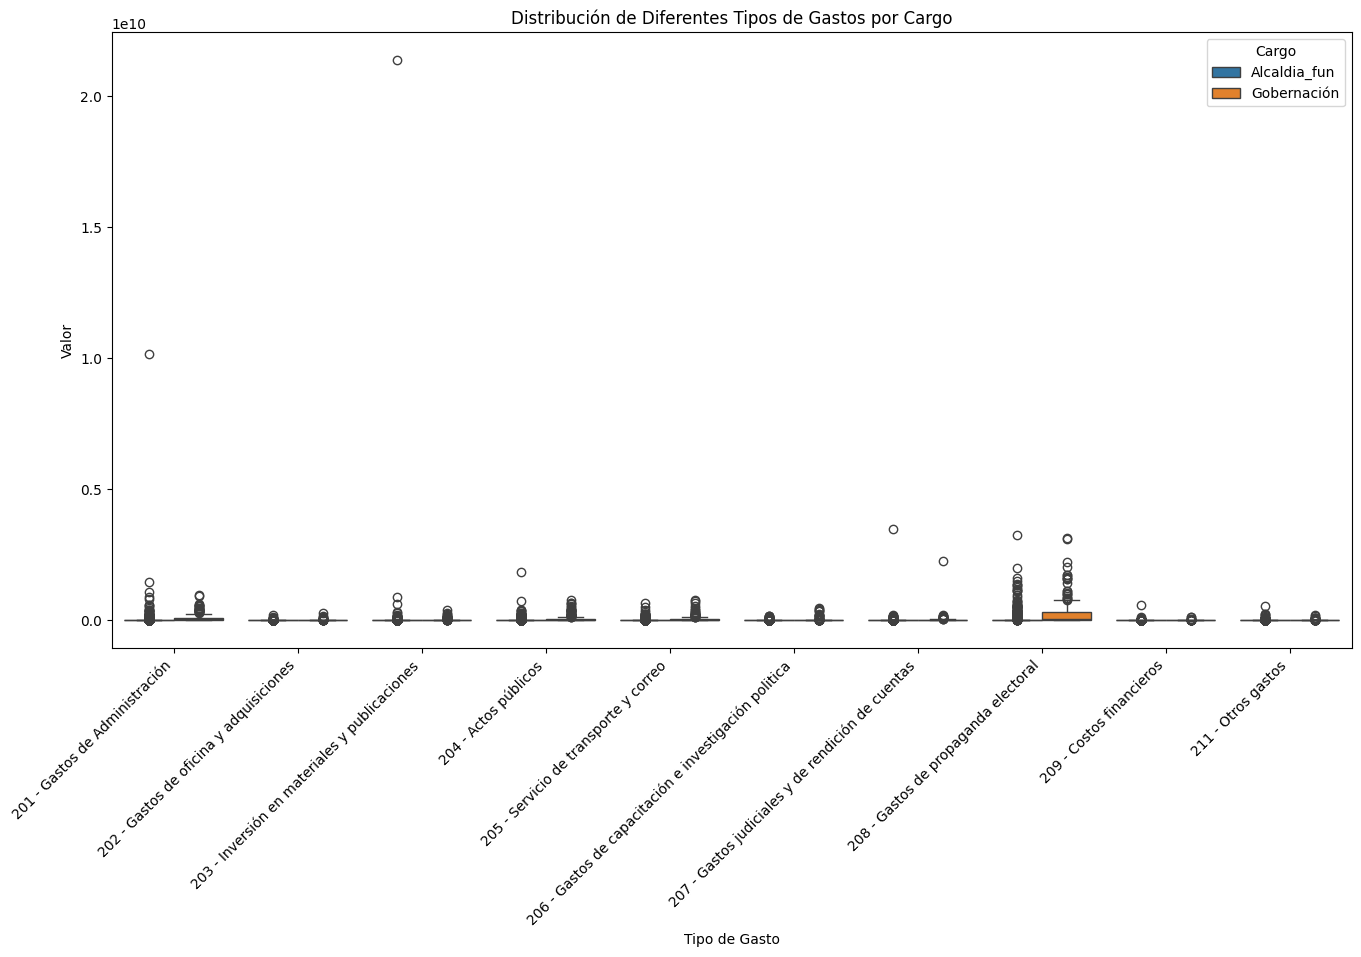

In [52]:
plt.figure(figsize=(16, 8))
df_melted = gastos_df_i2.melt(id_vars=['Cargo'], value_vars=gasto_columns, var_name='Tipo de Gasto', value_name='Valor')
sns.boxplot(x='Tipo de Gasto', y='Valor', hue='Cargo', data=df_melted)
plt.xticks(rotation=45, ha='right')
plt.title('Distribución de Diferentes Tipos de Gastos por Cargo')
plt.show()

In [53]:
for column in gasto_columns:
    proportion_column = 'proportion '+ column
    gastos_df_i2[proportion_column] = gastos_df_i2[column] / gastos_df_i2['Total de Gastos']

In [54]:
gastos_df_i2.head()

Nombre         Cargo Sexo Departamento     Ciudades  \
0     abad_de_jesus_marin_arcila  Alcaldia_fun    M    Antioquia   San Rafael   
1     abel_alberto_polanco_lemos  Alcaldia_fun    M      Bolívar     Tiquisio   
2     abel_angel_quiñones_urbano  Alcaldia_fun    M       Nariño     Ricaurte   
3     abel_antonio_cepeda_macias  Alcaldia_fun    M    Atlántico  Sabanalarga   
4  abel_antonio_paternina_orozco  Alcaldia_fun    M      Bolívar  Arroyohondo   

    Tipo de Agrupación                               Nombre de Agrupación  \
0  Agrupacion Politica                        PARTIDO COLOMBIA RENACIENTE   
1  Agrupacion Politica                          PARTIDO NUEVO LIBERALISMO   
2  Agrupacion Politica  MOVIMIENTO AUTORIDADES INDIGENAS DE COLOMBIA "...   
3  Agrupacion Politica                       PARTIDO DEMOCRATA COLOMBIANO   
4   Coalicion Politica                 NUEVO LIBERALISMO - CAMBIO RADICAL   

   Contar  201 - Gastos de Administración  \
0       4                             0.0   
1      19                             0.0   
2       6                       6300000.0   
3      15                             0.0   
4       1                             0.0   

   202 - Gastos de oficina y adquisiciones  ...  \
0                                      0.0  ...   
1                                      0.0  ...   
2                                      0.0  ...   
3                                      0.0  ...   
4                                      0.0  ...   

   proportion 201 - Gastos de Administración  \
0                                   0.000000   
1                                   0.000000   
2                                   0.663158   
3                                   0.000000   
4                                   0.000000   

   proportion 202 - Gastos de oficina y adquisiciones  \
0                                                0.0    
1                                                0.0    
2                                                0.0    
3                                                0.0    
4                                                0.0    

   proportion 203 - Inversión en materiales y publicaciones  \
0                                           0.000000          
1                                           0.111111          
2                                           0.000000          
3                                           0.396694          
4                                           0.000000          

   proportion 204 - Actos públicos  \
0                         0.000000   
1                         0.507407   
2                         0.000000   
3                         0.000000   
4                         0.000000   

   proportion 205 - Servicio de transporte y correo  \
0                                          0.571429   
1                                          0.362963   
2                                          0.000000   
3                                          0.000000   
4                                          0.000000   

   proportion 206 - Gastos de capacitación e investigación politica  \
0                                                0.0                  
1                                                0.0                  
2                                                0.0                  
3                                                0.0                  
4                                                0.0                  

   proportion 207 - Gastos judiciales y de rendición de cuentas  \
0                                           0.010989              
1                                           0.018519              
2                                           0.221053              
3                                           0.000000              
4                                           0.000000              

   proportion 208 - Gastos de propaganda electoral  \
0                                         0

In [55]:
df_melted_proportion = gastos_df_i2.melt(
    id_vars=['Nombre', 'Departamento', 'Total de Gastos'], 
    value_vars=[col + ' Proporción' for col in gasto_columns],
    var_name='Tipo de Gasto Proporción', 
    value_name='Proporción'
)

plt.figure(figsize=(14, 7))
sns.barplot(x='Tipo de Gasto Proporción', y='Proporción', data=df_melted_proportion)
plt.xticks(rotation=45, ha='right')
plt.title('Proporción de Cada Tipo de Gasto')
plt.show()

KeyError: "The following 'value_vars' are not present in the DataFrame: ['201 - Gastos de Administración Proporción', '202 - Gastos de oficina y adquisiciones Proporción', '203 - Inversión en materiales y publicaciones Proporción', '204 - Actos públicos Proporción', '205 - Servicio de transporte y correo Proporción', '206 - Gastos de capacitación e investigación politica Proporción', '207 - Gastos judiciales y de rendición de cuentas Proporción', '208 - Gastos de propaganda electoral Proporción', '209 - Costos financieros Proporción', '211 - Otros gastos Proporción']"

c:\Users\SergioxD\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


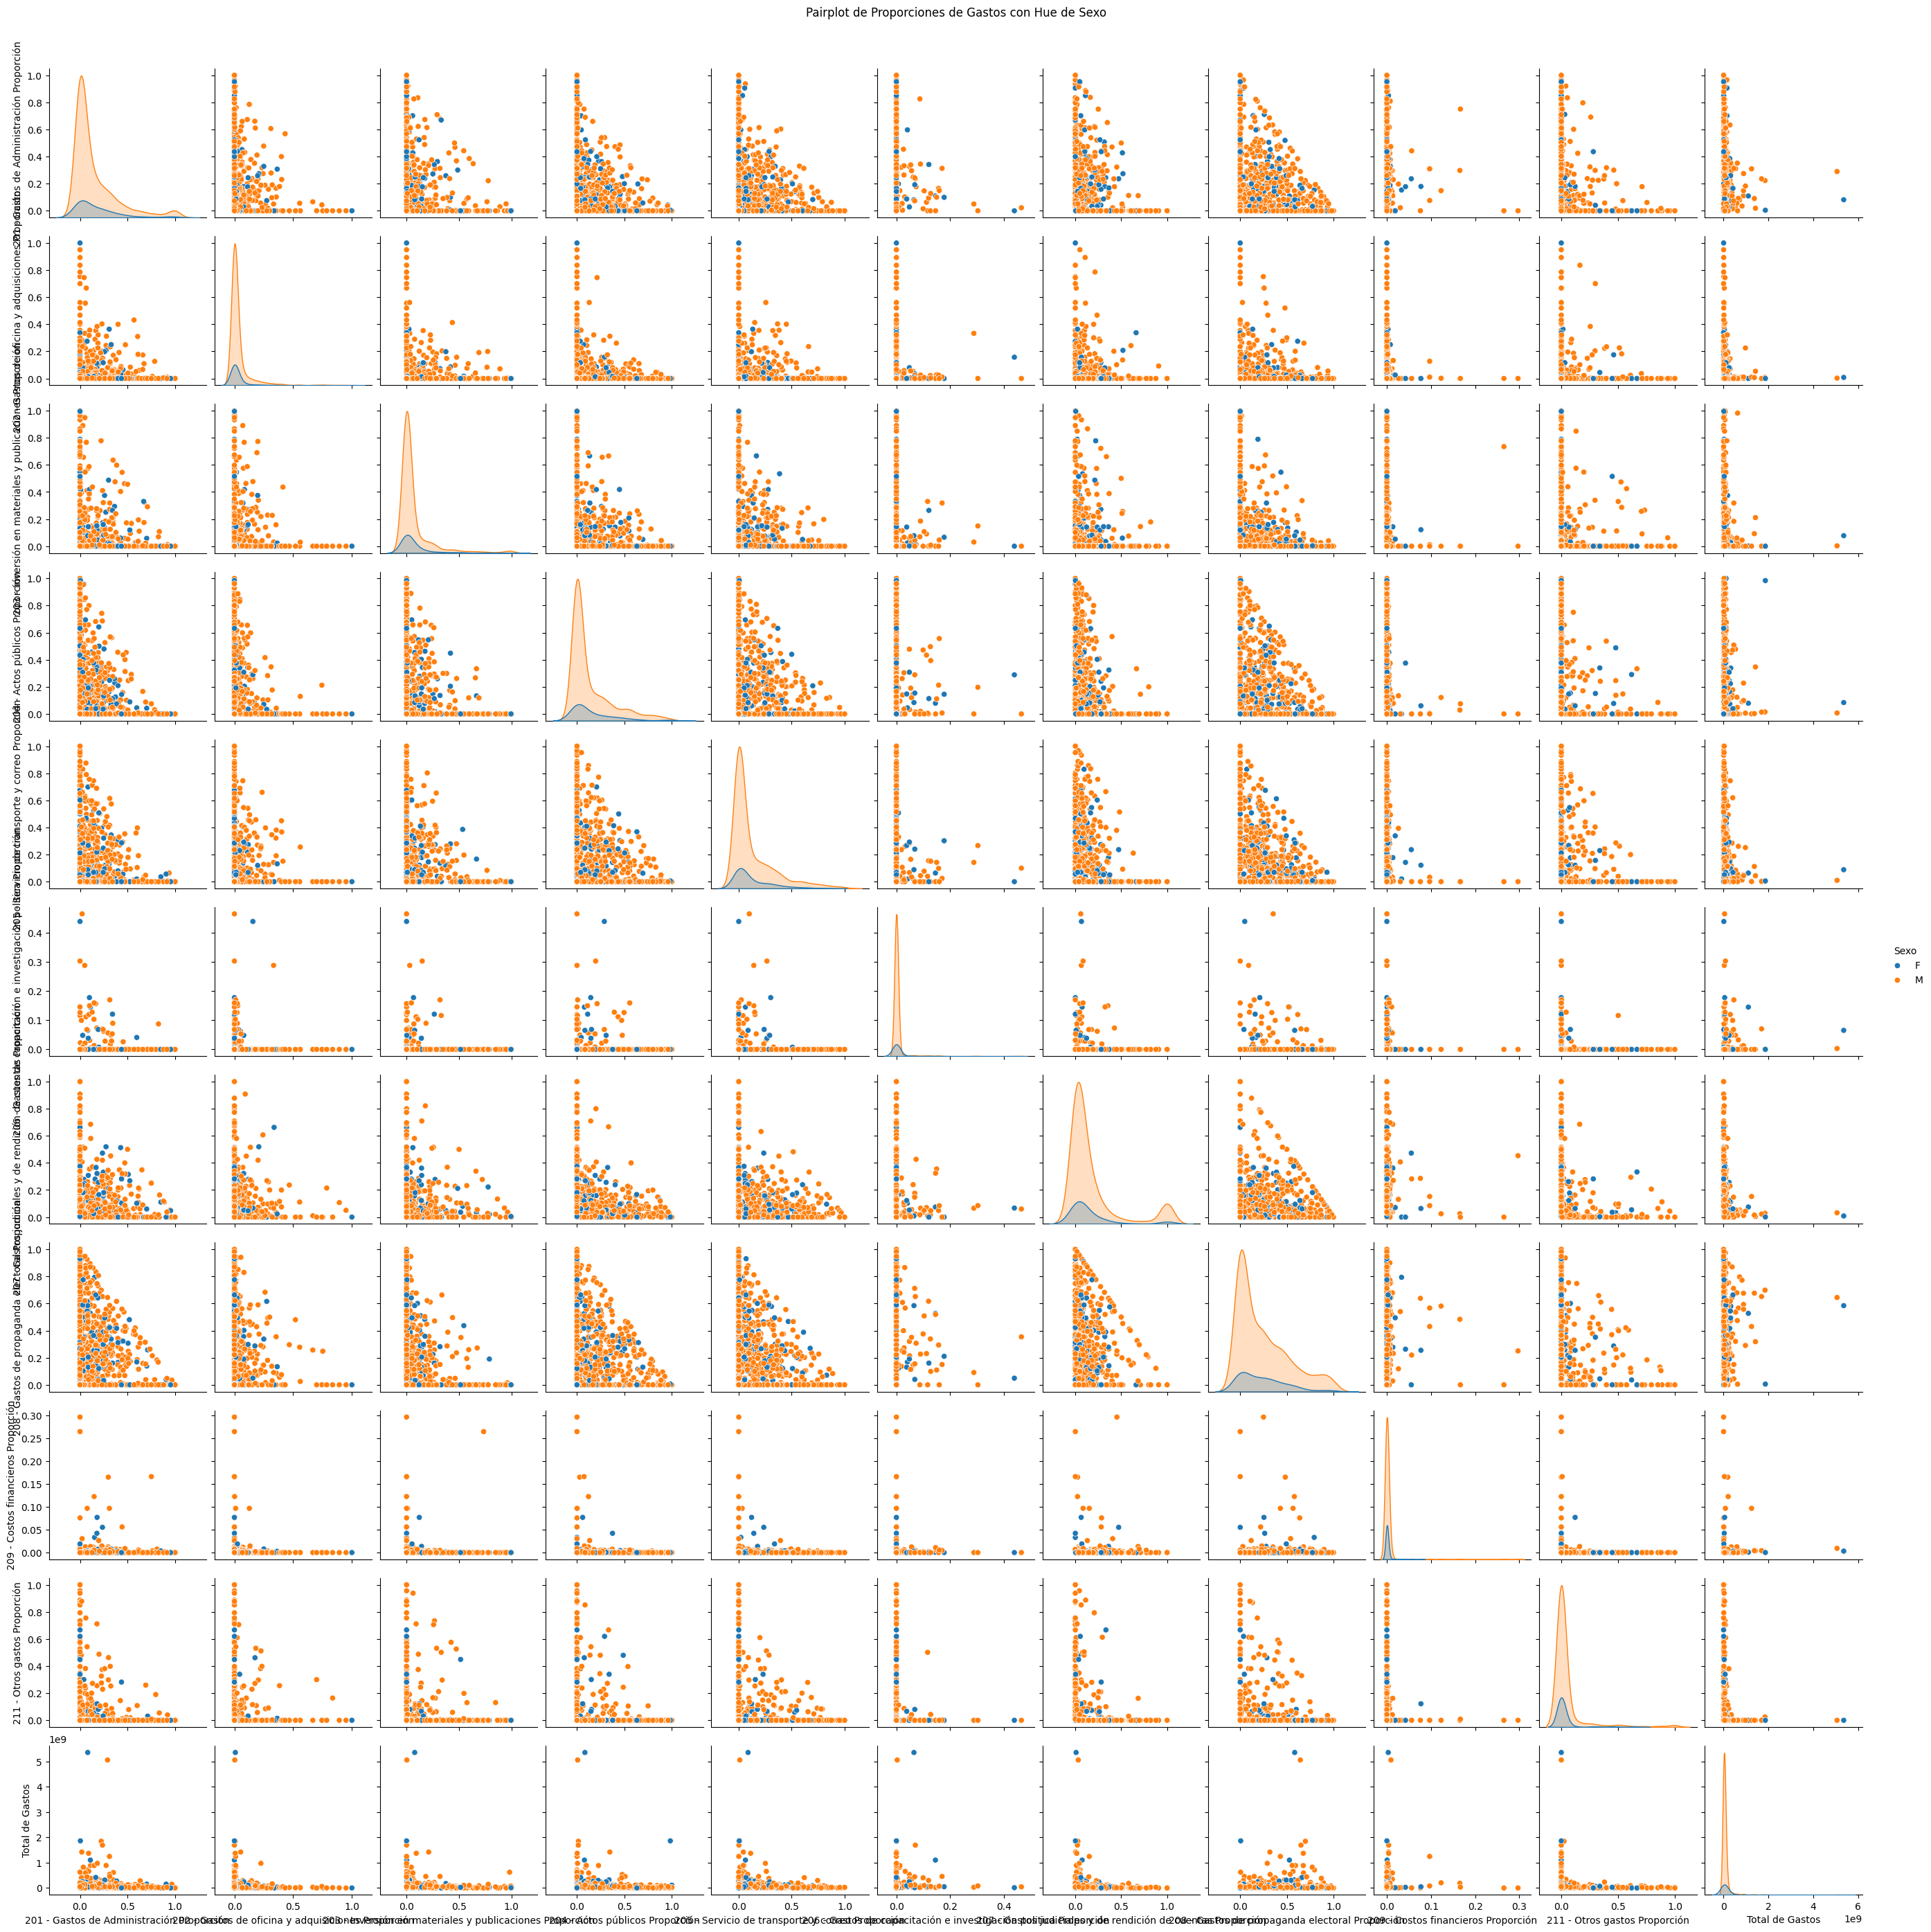

In [ ]:
# Suponiendo que ya tienes el DataFrame `df` con las columnas de proporciones
proportion_columns = [col + ' Proporción' for col in gasto_columns] + ['Total de Gastos']

# Crear una muestra del DataFrame si es necesario
sample_df = gastos_df_i2.sample(n=1000, random_state=42)  # Ajusta n según el tamaño de tu muestra

# Incluir algunas variables categóricas para el análisis
sample_df['Sexo'] = gastos_df_i2['Sexo']
sample_df['Departamento'] = gastos_df_i2['Departamento']

# Generar el pairplot
sns.pairplot(sample_df, hue='Sexo', vars=proportion_columns, diag_kind='kde')
plt.suptitle('Pairplot de Proporciones de Gastos con Hue de Sexo', y=1.02)
plt.show()

In [ ]:
# shapefile_path = (
#     "data/Servicios_PBAblicos_-_Municipios/Servicios_P%C3%BAblicos_-_Municipios"
# )


# gdf = gpd.read_file('data/Servicios_PBAblicos_-_Municipios/Servicios_P%C3%BAblicos_-_Municipios.shp')


# fig, ax = plt.subplots(figsize=(10, 10))

# # Dibujar el mapa base de Colombia
# gdf.plot(ax=ax, color='lightgray', edgecolor='black')


# def formatear_texto(texto):
#     return texto.lower().capitalize()

# # Aplicar la función a la columna 'DEPTO' del GeoDataFrame
# gdf["DEPTO"] = gdf["DEPTO"].apply(formatear_texto)

# # # Verificar los nombres de los atributos
# # print(gdf.columns)
# # # Verificar la información general del GeoDataFrame
# # print(gdf.info())

# # Fusionar el DataFrame con los datos de gasto en el GeoDataFrame
# gdf_con_gasto = gdf.merge(gastos_df, left_on='DEPTO', right_on='Departamento')

# # Crear la figura y los ejes
# fig, ax = plt.subplots(figsize=(10, 10))

# # Dibujar el mapa base de Colombia
# gdf_con_gasto.plot(ax=ax, color='lightgray', edgecolor='black')

# # Superponer los datos de gasto en el mapa
# gdf_con_gasto.plot(ax=ax, column='Total', legend=True)

# # Etiquetar los departamentos con el nombre y el gasto
# for index, row in gdf_con_gasto.iterrows():
#     ax.text(row.geometry.centroid.x, row.geometry.centroid.y, f"{row['DEPTO']}: ${row['Total']}",
#             fontsize=8, ha='center')

# # Ajustar el tamaño de la figura
# plt.tight_layout()

# # Mostrar el mapa
# plt.show()